In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import math
import os
import glob
import uuid

from datetime import datetime, timezone
from pathlib import Path

plt.style.use("ggplot")

# Estimate River Fluxes

This notebook loads **daily interpolated water chemistry** and cleaned **discharge** datasets from NetCDF files, harmonizes and merges the data by river and date, and computes and plots **daily, monthly, and annual fluxes**.


## How to run the analysis?
1. Clone the AquaINFRA GitHub repository.
2. Install the following Python packages:
   - `xarray`, `pandas`, `numpy`, `matplotlib`, `math`
3. Set up your inputs:
   - Paths to NetCDF files for daily interpolated water chemistry and cleaned discharge
4. Define metadata and mappings:
   - Rename station names to harmonize data (e.g., `q_station_rename_map`)
   - Define variable units and long names in `flux_metadata_df` and `standard_name_map`
   - Configure river coordinates (`river_coords`) and global NetCDF metadata (`global_metadata_config`)
5. Configure processing options:
   - Set column names (`date_col`, `station_col`, `discharge_col`)
   - Drop irrelevant columns
   - Define how interpolated fluxes are grouped (`daily`, `monthly`, `annual`)
6. Run the analysis

## Which programming languages are used?
- Python

## How does the workflow look like?
1. Define inputs and file paths  
2. Load NetCDF datasets (daily interpolated water chemistry and cleaned discharge)
3. Standardize date and station names 
4. Merge water chemistry and discharge by river and date
5. Extract units from NetCDF attributes
6. Compute daily fluxes using discharge x concentration with proper unit conversion
7. Aggregate daily fluxes to monthly and annual levels
8. Plot daily, monthly, and annual fluxes for each station
9. Save the datastes as netCDF files

## Which functions are used and how are they connected?
| Function | Description |
|---------|-------------|
| `load_netcdf_to_dataframes()` | Loads NetCDF files and converts them to DataFrames, handling date parsing |
| `process_river_dfs()` | Renames columns, standardizes dates, and harmonizes station names |
| `merge_daily_river_data()` | Merges discharge and chemistry into a daily time series per river |
| `extract_units_from_netcdf()` | Extracts units from NetCDF variable attributes |
| `compute_fluxes()` | Calculates daily fluxes for each parameter using discharge and units |
| `plot_daily_fluxes_per_river()` | Plots daily time series of fluxes per river and parameter |
| `plot_monthly_fluxes_per_river()` | Aggregates and plots monthly fluxes |
| `plot_annual_fluxes_per_river()` | Aggregates and plots annual fluxes using bar charts |


In [2]:
def load_netcdf_to_dataframes(filepaths, time_vars=("sample_date", "time")):
    """
    Loads a list of NetCDF files into pandas DataFrames.

    Parameters:
        filepaths: Paths to NetCDF files.
        time_vars: Column names to convert to datetime.

    Returns:
        list of tuples: Each tuple contains the filename and its corresponding DataFrame.
    """
    
    dataframes = []

    for fp in filepaths:
        ds = xr.open_dataset(fp)
        df = ds.to_dataframe().reset_index()

        for time_var in time_vars:
            if time_var in df.columns:
                df[time_var] = pd.to_datetime(df[time_var], errors="coerce")

        dataframes.append((Path(fp).name, df))
    
    return dataframes

def process_river_dfs(dfs, time_col_name, station_rename_map, date_col="date", station_col="station_name", standard_station_col="river_name"):
    """
    Processes a list of DataFrames by:
    - Renaming the time column to a consistent name
    - Converting the date column to datetime
    - Normalizing timestamps to keep only the date part
    - Renaming station names using the provided mapping
    - Renaming the station column to a standard name (e.g. 'river_name')

    Parameters:
        dfs: List of (filename, DataFrame) from NetCDF files.
        time_col_name: Name of the time column to convert and rename.
        station_rename_map: Dict to standardize station names.
        date_col: New name for the time column (default: "date").
        station_col: Name of the original station column (default: "station_name").
        standard_station_col: Final name for the renamed station column (default: "river_name").

    Returns:
        List of tuples: (filename, processed DataFrame)
    """
    processed_dfs = []

    for fname, df in dfs:

        if time_col_name in df.columns:
            df = df.rename(columns={time_col_name: date_col})
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
        df[date_col] = df[date_col].dt.normalize()

        if station_col in df.columns:
            df[station_col] = df[station_col].replace(station_rename_map)
            df = df.rename(columns={station_col: standard_station_col})

        processed_dfs.append((fname, df))

    return processed_dfs

def merge_daily_river_data(wc_dfs, q_dfs, station_col="river_name", date_col="date", discharge_col="discharge", drop_cols=False):
    """
    Merge water chemistry and discharge data per river into daily time series,
    handling duplicates by aggregating (mean over duplicate days).

    Parameters:
        wc_dfs: List of (filename, DataFrame) tuples for water chemistry.
        q_dfs: List of (filename, DataFrame) tuples for discharge.
        station_col: Column name used to match stations (default: 'river_name').
        date_col: Name of the date column to align on (default: 'date').
        discharge_col: Name of the discharge column (default: 'discharge').
        drop_cols: List of column names to drop from water chemistry data before merging.
                   Set to False to skip dropping any columns.
                   
    Returns:
        List of (station_name, merged DataFrame) tuples.
    """
    merged_river_dfs = []

    for wc_fname, wc_df in wc_dfs:
        station_name = wc_df[station_col].iloc[0]

        q_match = [q_df for _, q_df in q_dfs if q_df[station_col].iloc[0] == station_name]
        
        if not q_match:
            print(f"No discharge data for station '{station_name}'")
            continue
            
        q_df = q_match[0]

        q_df = q_df.drop_duplicates(subset=date_col)

        full_dates = pd.date_range(start=q_df[date_col].min(), end=q_df[date_col].max(), freq='D')
        full_df = pd.DataFrame({date_col: full_dates})

        merged = pd.merge(full_df, q_df[[date_col, discharge_col]], on=date_col, how='left')

        if isinstance(drop_cols, list):
            wc_df = wc_df.drop(columns=drop_cols, errors='ignore')

        merged = pd.merge(merged, wc_df, on=date_col, how='left')

        merged = merged.drop(columns=[station_col], errors='ignore')

        numeric_cols = merged.select_dtypes(include='number').columns.tolist()
        agg_df = (merged.groupby(date_col)[numeric_cols].mean().reset_index())

        agg_df[station_col] = station_name

        columns_order = [date_col, station_col, discharge_col] + [col for col in agg_df.columns if col not in [date_col, station_col, discharge_col]]
        agg_df = agg_df[columns_order]

        merged_river_dfs.append((station_name, agg_df))

    return merged_river_dfs


def extract_units_from_netcdf(netcdf_path, skip_vars=["date", "latitude", "longitude", "river_name"]):
    """
    Extracts units from a NetCDF file and returns a DataFrame like pars_metadata_df.
    """
    ds = xr.open_dataset(netcdf_path)
    metadata = []

    for var in ds.data_vars:
        if var in skip_vars:
            continue
        unit = ds[var].attrs.get("units", "unknown")
        metadata.append({"parameter_name": var, "unit": unit})

    return pd.DataFrame(metadata)

def compute_fluxes(df, param_unit_map, discharge_col="discharge", keep_cols=("date", "river_name")):
    """
    Compute daily fluxes for a river dataframe.

    - Concentration units are handled based on `param_unit_map`.
    - Discharge must be in m³/s (converted internally).
    - Output includes flux variables, date, and river name.

    Parameters:
        df: DataFrame with daily data (must include discharge and concentration variables)
        param_unit_map: dict mapping variable names to their units
        discharge_col: name of the discharge column
        keep_cols: additional columns to retain (like date, river_name)

    Returns:
        DataFrame with fluxes and metadata columns.
    """
    q_m3_per_day = df[discharge_col] * 86400  # m³/s to m³/day
    flux_df = pd.DataFrame(index=df.index)

    for var in df.columns:
        if var in keep_cols or var == discharge_col:
            continue
        if var not in param_unit_map:
            print(f"Skipping {var}: unit not found in metadata.")
            continue

        unit = param_unit_map[var]

        # Convert to kg/m³
        if unit.endswith(("mg/l", "mg/l C", "mg Pt/l")):
            conc_kg_m3 = df[var] * 1e-3
        elif unit.endswith(("µg/l", "μg/l", "µg/l P")):
            conc_kg_m3 = df[var] * 1e-6
        elif unit.endswith("Abs/cm"):
            conc_kg_m3 = df[var]  # use raw values -> they’re not in tonnes/day!!!!!!
        else:
            print(f"Unknown unit for {var}: {unit}. Skipping.")
            continue

        flux = conc_kg_m3 * q_m3_per_day / 1000  # tonnes/day or Abs·m³/day
        flux_df[var] = flux  

    # Add metadata columns
    for col in keep_cols:
        flux_df[col] = df[col]

    return flux_df


def plot_daily_fluxes(flux_results, station_filter=None, variables_to_plot=None, cols=3, figsize=(15, 12), non_mass_flux_vars=None, save_path=None):
    """
    Plot daily fluxes for a specific river station using line plots.

    Parameters:
        flux_results: List of (station_name, DataFrame) pairs with daily flux data.
        station_filter: Name of the station to plot.
        variables_to_plot: Specific variable names to include. If None, plots all available.
        cols: Number of columns in the subplot grid.
        figsize: Overall figure size in inches (width, height).
        non_mass_flux_vars: List of variable names that should not be labeled as "tonnes/day".
        save_path: If provided, saves the figure to this file path.

    Returns:
        None. Saves and/or displays a matplotlib figure.
    """
    if non_mass_flux_vars is None:
        non_mass_flux_vars = ["Color", "UV_Abs_254nm", "UV_Abs_410nm"]

    match = [(name, df) for name, df in flux_results if name == station_filter]
    if not match:
        print(f"Station '{station_filter}' not found.")
        return

    station_name, df = match[0]
    df = df.copy().sort_values("date")

    flux_vars = df.select_dtypes(include='number').columns.difference(["discharge"])
    if variables_to_plot:
        flux_vars = [v for v in variables_to_plot if v in flux_vars]
    else:
        flux_vars = [v for v in flux_vars if not df[v].isna().all()]

    rows = math.ceil(len(flux_vars) / cols)
    fig_height = 3 * rows
    fig_width = 5 * cols

    fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height), sharex=False)
    axes = axes.flatten()

    for i, var in enumerate(flux_vars):
        axes[i].plot(df["date"], df[var])
        axes[i].set_title(var)
        axes[i].tick_params(axis='x', labelrotation=45)

        if var not in non_mass_flux_vars:
            axes[i].set_ylabel("tonnes/day")

        axes[i].grid(True)

    for j in range(len(flux_vars), len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"{station_name} – Daily Fluxes", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.96])

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Saved plot to: {save_path}")
        
    plt.show()


def plot_monthly_fluxes(monthly_flux_results, station_filter=None, variables_to_plot=None, cols=3, figsize=(15, 12), non_mass_flux_vars=None, save_path=None):
    """
    Plot monthly fluxes for a specific river station using line plots.

    Parameters:
        monthly_flux_results: List of (station_name, DataFrame) pairs with monthly flux data.
        station_filter: Name of the station to plot.
        variables_to_plot: Specific variable names to include. If None, plots all available.
        cols: Number of columns in the subplot grid.
        figsize: Overall figure size in inches (width, height).
        non_mass_flux_vars: List of variables that should not be labeled as "tonnes/month".
        save_path: If provided, saves the figure to this file path.

    Returns:
        None. Saves and/or displays a matplotlib figure.
    """
    if non_mass_flux_vars is None:
        non_mass_flux_vars = ["Color", "UV_Abs_254nm", "UV_Abs_410nm"]

    match = [(name, df) for name, df in monthly_flux_results if name == station_filter]
    if not match:
        print(f"Station '{station_filter}' not found.")
        return

    station_name, df = match[0]
    df = df.copy().sort_values("date")

    flux_vars = df.select_dtypes(include='number').columns.difference(["discharge"])
    if variables_to_plot:
        flux_vars = [v for v in variables_to_plot if v in flux_vars]
    else:
        flux_vars = [v for v in flux_vars if not df[v].isna().all()]

    rows = math.ceil(len(flux_vars) / cols)
    fig_height = 3 * rows
    fig_width = 5 * cols

    fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height), sharex=False)
    axes = axes.flatten()

    for i, var in enumerate(flux_vars):
        axes[i].plot(df.index, df[var], marker="o")
        axes[i].set_title(var)
        axes[i].tick_params(axis='x', labelrotation=45)

        if var not in non_mass_flux_vars:
            axes[i].set_ylabel("tonnes/month")

        axes[i].grid(True)

    for j in range(len(flux_vars), len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"{station_name} – Monthly Fluxes", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.96])

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Saved plot to: {save_path}")
        
    plt.show()
    

def plot_annual_fluxes(annual_flux_results, station_filter=None, variables_to_plot=None, cols=3, figsize=(15, 12), non_mass_flux_vars=None, save_path=None):
    """
    Plot annual fluxes for a specific river station using line plots.

    Parameters:
        annual_flux_results: List of (station_name, DataFrame) pairs with annual flux data.
        station_filter: Name of the station to plot.
        variables_to_plot: Specific variable names to include. If None, plots all.
        cols: Number of columns in the subplot grid.
        figsize: Figure size (width, height) in inches.
        non_mass_flux_vars: List of variable names that should NOT be labeled as "tonnes/year".
        save_path: If provided, saves the figure to this file path.

    Returns:
        None. Saves and/or displays a matplotlib figure.
    """
    # Default non-mass-based variables
    if non_mass_flux_vars is None:
        non_mass_flux_vars = ["Color", "UV_Abs_254nm", "UV_Abs_410nm"]

    match = [(name, df) for name, df in annual_flux_results if name == station_filter]
    if not match:
        print(f"Station '{station_filter}' not found.")
        return

    station_name, df = match[0]
    df = df.copy().sort_values("year")

    flux_vars = df.select_dtypes(include='number').columns.difference(["year", "discharge"])
    if variables_to_plot:
        flux_vars = [v for v in variables_to_plot if v in flux_vars]
    else:
        flux_vars = [v for v in flux_vars if not df[v].isna().all()]

    rows = math.ceil(len(flux_vars) / cols)
    fig_height = 3 * rows
    fig_width = 5 * cols

    fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height), sharex=False)
    axes = axes.flatten()

    for i, var in enumerate(flux_vars):
        axes[i].plot(df["year"], df[var], marker="o")
        axes[i].set_title(var)
        axes[i].tick_params(axis='x', labelrotation=45)

        if var not in non_mass_flux_vars:
            axes[i].set_ylabel("tonnes/year")

        valid_years = df.loc[df[var].notna(), "year"]
        axes[i].set_xticks(valid_years)
        axes[i].grid(True)

    for j in range(len(flux_vars), len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"{station_name} – Annual Fluxes", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Saved plot to: {save_path}")
        
    plt.show()



def save_flux_datasets_as_netcdf(flux_results, output_dir, frequency_label, river_coords, flux_metadata_df, standard_name_map, var_comments, processed_namespace_uuid, global_metadata_config):
    """
    Save water chemistry flux estimates as NetCDF files, including metadata and CF-compliant structure.
    
    Parameters:
        flux_results: List of (station_name, DataFrame) pairs containing flux values and metadata columns.
                      The DataFrame must have a datetime index (daily, monthly, or annual resolution).
        output_dir: Directory where NetCDF files will be saved (Path or str).
        frequency_label: Frequency label (e.g., "daily", "monthly", "annual").
        river_coords: Dict mapping station names to {"lat": float, "lon": float}.
        flux_metadata_df: DataFrame with columns ['parameter_name', 'unit'].
        standard_name_map: Dict mapping variable names to descriptive names.
        var_comments: Dict of comments per variable and station: {var: {station: comment}}.
        processed_namespace_uuid: UUID namespace used for generating persistent dataset UUIDs.
        global_metadata_config: Dict of global metadata following ACDD/CF conventions.

    Returns:
        None. Saves NetCDF files to disk.
    """

    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    for station_name, df in flux_results:
        df = df.copy()

        # Ensure datetime index
        if not pd.api.types.is_datetime64_any_dtype(df.index):
            if "date" in df.columns:
                df["date"] = pd.to_datetime(df["date"])
                df = df.set_index("date")
            else:
                raise ValueError(f"DataFrame for {station_name} has no datetime index or 'date' column.")

        df.index.name = "date"  # <-- Set name explicitly

        ds = xr.Dataset.from_dataframe(df)
        ds = ds.assign_coords(date=("date", df.index))  # <-- Use 'date' coordinate
        ds["date"].attrs.update({
            "standard_name": "time",
            "long_name": "Time of measurement",
            "axis": "T"
        })

        # Add lat/lon if available
        if station_name in river_coords:
            coords = river_coords[station_name]
            ds = ds.assign_coords(
                latitude=xr.DataArray(coords["lat"], dims=(), attrs={
                    "standard_name": "latitude",
                    "long_name": "Latitude",
                    "units": "degree_north"
                }),
                longitude=xr.DataArray(coords["lon"], dims=(), attrs={
                    "standard_name": "longitude",
                    "long_name": "Longitude",
                    "units": "degree_east"
                }),
            )
            ds = ds.set_coords(["latitude", "longitude"])

        # River name
        ds["river_name"] = xr.DataArray(station_name, dims=(), attrs={"cf_role": "timeseries_id"})

        # Add variable metadata
        for var in ds.data_vars:
            if var in ["date", "latitude", "longitude", "river_name"]:
                continue
            if var in flux_metadata_df["parameter_name"].values:
                match = flux_metadata_df[flux_metadata_df["parameter_name"] == var].iloc[0]
                ds[var].attrs["units"] = match["unit"]
                ds[var].attrs["long_name"] = standard_name_map.get(var, var)
            if var_comments.get(var) and station_name in var_comments[var]:
                ds[var].attrs["comment"] = var_comments[var][station_name]

        # Metadata
        unique_id = f"no.niva:{uuid.uuid5(processed_namespace_uuid, station_name)}"
        lat = float(ds.latitude.values.item()) if "latitude" in ds.coords else np.nan
        lon = float(ds.longitude.values.item()) if "longitude" in ds.coords else np.nan

        dataset_metadata = global_metadata_config.copy()
        dataset_metadata.update({
            "id": unique_id,
            "title": f"{frequency_label.capitalize()} water chemistry fluxes for river {station_name}",
            "title_no": f"Estimerte {frequency_label} flukser av vannkjemi for elv {station_name}",
            "summary": f"{frequency_label.capitalize()} time series of water chemistry for river {station_name}, estimated by harmonizing observed data and interpolating missing values.",
            "summary_no": f"{frequency_label.capitalize()} tidsserier for vannkjemi ved elv {station_name}, beregnet ved å harmonisere observerte målinger og interpolere manglende verdier.",
            "date_created": datetime.now(timezone.utc).strftime("%Y-%m-%dT%H:%M:%SZ"),
            "time_coverage_start": str(ds.date.min().values),
            "time_coverage_end": str(ds.date.max().values),
            "geospatial_lat_min": lat,
            "geospatial_lat_max": lat,
            "geospatial_lon_min": lon,
            "geospatial_lon_max": lon,
        })

        if frequency_label == "daily":
            dataset_metadata["processing_level"] = "Estimated daily mass fluxes based on preprocessed water chemistry and discharge time series."
            dataset_metadata["history"] = "Fluxes were estimated using harmonized daily water chemistry concentrations and discharge data. Concentration units were converted to mass per volume where applicable, and fluxes were calculated as mass transport per day."
        else:
            dataset_metadata["processing_level"] = "Aggregated fluxes derived from daily estimates."
            dataset_metadata["history"] = f"Daily fluxes were estimated using water chemistry and discharge data, then aggregated to {frequency_label} totals."

        ds.attrs = {k: str(v) for k, v in dataset_metadata.items()}

        # Encoding: use 'date', not 'time'
        encoding = {
            "date": {
                "dtype": "int32",
                "_FillValue": None,
                "units": "seconds since 1970-01-01 00:00:00",
            },
            "latitude": {"_FillValue": None},
            "longitude": {"_FillValue": None},
        }

        # Add integer encoding for numeric vars
        for var in ds.data_vars:
            if var in ["date", "latitude", "longitude", "river_name"]:
                continue
            if np.issubdtype(ds[var].dtype, np.number):
                encoding[var] = {"dtype": "int32", "_FillValue": -9999}

        fname = f"{frequency_label}_water_chemistry_fluxes_{station_name.lower().replace(' ', '_')}.nc"
        output_path = output_dir / fname
        ds.to_netcdf(output_path, encoding=encoding, format="NETCDF4")
        print(f"Saved: {output_path}")

### 0. Inputs

In [3]:
# Define input files 
wc_interp_data_dir = Path("../../data/river/water_chemistry/daily_estimations")
wc_interp_data_fpaths = list(wc_interp_data_dir.glob("daily_water_chemistry_modeled_*.nc"))

q_cleaned_data_dir = Path("../../data/river/discharge/clean")
q_cleaned_data_fpaths = list(q_cleaned_data_dir.glob("Q_daily_mean_*.nc"))

water_chemistry_file_path = '../../data/river/water_chem/estimations/water_chem_daily_estimations.csv'
discharges_path = '../../data/river/discharge/clean'

# Define renaming maps
q_station_rename_map = {
    "Mjondalen bru": "Drammenselva",
    "Solbergfoss": "Glomma",
    "Holmfoss": "Numedalslagen"
}

# Name of columns to harmonize in all data sets
date_col = "date"
station_col = "river_name"
discharge_col = "discharge"

# Define unnecessary columns 
columns_to_drop = ['latitude', 'longitude', 'station_id', 'station_code', 'station_type']


# Metadata for saving as netCDF
river_coords = {
    "Drammenselva": {"lat": 59.75257593, "lon": 10.00789751},
    "Numedalslagen": {"lat": 59.10128295, "lon": 10.07094871},
    "Glomma": {"lat": 59.27980207, "lon": 11.13411158}
}

rivers = ["Glomma", "Drammenselva", "Numedalslagen"]

# Parameters metadata
flux_metadata_df = pd.DataFrame({
    "parameter_name": ["DOC", "Color", "NH4-N", "NO3-N", "TRP", "POC", "POC_calc", "TOC_calc", "SPM", "SiO2", "TOC", "TOTN", "TOTP", "TDP", "DIN", 
                       "DON", "PP", "TSM", "UV_Abs_254nm", "UV_Abs_410nm"],
    "unit":  ["tonnes", "undefined", "tonnes", "tonnes", "tonnes", "tonnes", "tonnes", "tonnes", "tonnes", "tonnes", "tonnes", "tonnes", "tonnes", "tonnes", "tonnes", 
              "tonnes", "tonnes", "tonnes", "undefined", "undefined"]
})

# Define metadata columns name 
flux_par_name_col = "parameter_name"
flux_unit_col = "unit"

# Define a mapping from parameter names to long names
standard_name_map = {
    "DOC": "Dissolved Organic Carbon",
    "Color": "Water Color",
    "NH4-N": "Ammonium-N",
    "NO3-N": "Nitrate-N",
    "TRP": "Total Reactive Phosphorus",
    "POC": "Particulate Organic Carbon",
    "TOC_calc": "Total Organic Carbon Calculated",
    "SPM": "Suspended Particulate Matter", 
    "SiO2": "Silicate", 
    "TOC": "Total Organic Carbon",
    "TOTN": "Total Nitrogen",
    "TOTP": "Total Phosphorus",
    "TDP": "Total Dissolved Phosphorus",
    "DIN": "Dissolved Inorganic Nitrogen",
    "DON": "Dissolved Organic Nitrogen",
    "PP": "Particulate Phosphorus",
    "TSM": "Total Suspended Matter",
    "UV_Abs_254nm": "Ultraviolet Absorbance 254nm",
    "UV_Abs_410nm": "Ultraviolet Absorbance 410nm",
}

# Comments for selected variables
var_comments = {
     "Color": {
        "Drammenselva": "This variable does NOT represent actual mass transport (e.g., in tonnes). It is included only as proxy to show how such parameters may vary with river discharge. Interpret this qualitatively, not quantitatively.",
        "Glomma": "This variable does NOT represent actual mass transport (e.g., in tonnes). It is included only as proxy to show how such parameters may vary with river discharge. Interpret this qualitatively, not quantitatively.",
        "Numedalslagen": "This variable does NOT represent actual mass transport (e.g., in tonnes). It is included only as proxy to show how such parameters may vary with river discharge. Interpret this qualitatively, not quantitatively."
    },
     "UV_Abs_254nm": {
        "Drammenselva": "This variable does NOT represent actual mass transport (e.g., in tonnes). It is included only as proxy to show how such parameters may vary with river discharge. Interpret this qualitatively, not quantitatively.",
        "Glomma": "This variable does NOT represent actual mass transport (e.g., in tonnes). It is included only as proxy to show how such parameters may vary with river discharge. Interpret this qualitatively, not quantitatively.",
        "Numedalslagen": "This variable does NOT represent actual mass transport (e.g., in tonnes). It is included only as proxy to show how such parameters may vary with river discharge. Interpret this qualitatively, not quantitatively."
    },
    "UV_Abs_410nm": {
        "Drammenselva": "This variable does NOT represent actual mass transport (e.g., in tonnes). It is included only as proxy to show how such parameters may vary with river discharge. Interpret this qualitatively, not quantitatively.",
        "Glomma": "This variable does NOT represent actual mass transport (e.g., in tonnes). It is included only as proxy to show how such parameters may vary with river discharge. Interpret this qualitatively, not quantitatively.",
        "Numedalslagen": "This variable does NOT represent actual mass transport (e.g., in tonnes). It is included only as proxy to show how such parameters may vary with river discharge. Interpret this qualitatively, not quantitatively."
    }
}

global_metadata_config = {
    "naming_authority": "no.niva",
    "project": "AquaINFRA",
    "iso_topic_category": "inlandWaters",
    "featureType": "timeSeries",
    "spatial_representation": "point",
    "creator_type": "institution",
    "creator_institution": "Norwegian Institute for Water Research (NIVA)",
    "institution": "Norwegian Institute for Water Research (NIVA)",
    "institution_short_name": "NIVA",
    "creator_name": "Areti Balkoni",
    "creator_email": "areti.balkoni@niva.no",
    "creator_url": "https://www.niva.no/en/employees/areti-balkoni",
    "data_owner": "Norwegian Institute for Water Research",
    "Conventions": "CF-1.7, ACDD-1.3",
    "publisher_name": "Norwegian Institute for Water Research",
    "publisher_email": "miljoinformatikk@niva.no",
    "publisher_institution": "Norwegian Institute for Water Research",
    "publisher_url": "https://niva.no",
    "license": "http://spdx.org/licenses/CC-BY-4.0(CC-BY-4.0)",
    "keywords": "GCMDSK:EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > WATER QUALITY/ WATER CHEMISTRY, GCMDLOC:CONTINENT > EUROPE > NORWAY",
    "keywords_vocabulary": "GCMDSK:GCMD Science Keywords, GCMDLOC:GCMD Locations",
    "comment": (
        'Parameters like "UV_Abs_254nm", "UV_Abs_410nm", and "Color" (measured in Abs/cm or mg Pt/l) '
        'are not mass concentrations. Fluxes for these variables do NOT represent actual '
        'mass transport (e.g., in tonnes). They are included only as proxies to show how '
        'such parameters may vary with river discharge. Interpret these qualitatively, not quantitatively.'
    )
}

processed_namespace_uuid = uuid.UUID("a23b7946-1a42-4d4a-bb0d-cf5a6cfb5670") 

int_encoding = {"dtype": "int32", "_FillValue": -9999}

# Where to save
# Plots
plots_output_dir = Path("../../figures/wc_fluxes")
plots_output_dir.mkdir(parents=True, exist_ok=True)

# Data
output_dir = "../../data/river/water_chemistry/fluxes"
os.makedirs(output_dir, exist_ok=True)

### 1. Load data

In [4]:
wc_dfs = load_netcdf_to_dataframes(wc_interp_data_fpaths, time_vars=("date", "time"))
q_dfs = load_netcdf_to_dataframes(q_cleaned_data_fpaths, time_vars=("date", "time"))

### 2. Data preparation 

In [5]:
# Process both types of data
q_dfs = process_river_dfs(q_dfs, time_col_name="time", station_rename_map=q_station_rename_map, date_col=date_col, station_col="station_name", standard_station_col=station_col)

# Merge data for easier processing
merged_rivers = merge_daily_river_data(wc_dfs, q_dfs, station_col, date_col, discharge_col, drop_cols=columns_to_drop)
merged_rivers

[('Drammenselva',
              date    river_name  discharge  DOC  Color  NH4-N  NO3-N  TRP  POC  \
  0     1990-01-01  Drammenselva    264.683  NaN    NaN    NaN    NaN  NaN  NaN   
  1     1990-01-02  Drammenselva    264.683  NaN    NaN    NaN    NaN  NaN  NaN   
  2     1990-01-03  Drammenselva    260.215  NaN    NaN    NaN    NaN  NaN  NaN   
  3     1990-01-04  Drammenselva    260.215  NaN    NaN    NaN    NaN  NaN  NaN   
  4     1990-01-05  Drammenselva    260.215  NaN    NaN    NaN    NaN  NaN  NaN   
  ...          ...           ...        ...  ...    ...    ...    ...  ...  ...   
  12653 2024-08-23  Drammenselva    508.867  NaN    NaN    NaN    NaN  NaN  NaN   
  12654 2024-08-24  Drammenselva    591.747  NaN    NaN    NaN    NaN  NaN  NaN   
  12655 2024-08-25  Drammenselva    669.755  NaN    NaN    NaN    NaN  NaN  NaN   
  12656 2024-08-26  Drammenselva    733.868  NaN    NaN    NaN    NaN  NaN  NaN   
  12657 2024-08-27  Drammenselva    688.792  NaN    NaN    NaN    NaN

### 3. Estimate fluxes

#### 3.1 Daily

In [6]:
daily_flux_results = []

for (station_name, merged_df), nc_path in zip(merged_rivers, wc_interp_data_fpaths):
    print(f"Processing: {station_name}")
    
    # Extract parameter units from netCDF
    param_meta_df = extract_units_from_netcdf(nc_path)
    param_unit_map = dict(zip(param_meta_df["parameter_name"], param_meta_df["unit"]))
    
    # Compute fluxes
    df_with_fluxes = compute_fluxes(merged_df, param_unit_map, discharge_col=discharge_col)
    
    daily_flux_results.append((station_name, df_with_fluxes))

Processing: Drammenselva
Processing: Glomma
Processing: Numedalslagen


#### 3.2 Monthly and annual

In [7]:
monthly_flux_results = []
annual_flux_results = []

for station_name, daily_df in daily_flux_results:
    print(f"Aggregating: {station_name}")
    
    # Ensure 'date' is datetime and set as index
    daily_df = daily_df.copy()
    daily_df["date"] = pd.to_datetime(daily_df["date"])
    daily_df = daily_df.set_index("date")

    # Monthly flux: require at least 25 valid daily values
    monthly_df = daily_df.resample("M").sum(min_count=25)
    monthly_df["river_name"] = station_name
    monthly_df["month"] = monthly_df.index.to_period("M").astype(str)
    monthly_flux_results.append((station_name, monthly_df))

    # Annual flux: require at least 350 valid daily values
    annual_df = daily_df.resample("Y").sum(min_count=350)
    annual_df["river_name"] = station_name
    annual_df["year"] = annual_df.index.year
    annual_flux_results.append((station_name, annual_df))

Aggregating: Drammenselva
Aggregating: Glomma
Aggregating: Numedalslagen


C:\Users\ARB\AppData\Local\Temp\ipykernel_23576\1668936242.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = daily_df.resample("M").sum(min_count=25)
C:\Users\ARB\AppData\Local\Temp\ipykernel_23576\1668936242.py:19: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_df = daily_df.resample("Y").sum(min_count=350)
C:\Users\ARB\AppData\Local\Temp\ipykernel_23576\1668936242.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = daily_df.resample("M").sum(min_count=25)
C:\Users\ARB\AppData\Local\Temp\ipykernel_23576\1668936242.py:19: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_df = daily_df.resample("Y").sum(min_count=350)
C:\Users\ARB\AppData\Local\Temp\ipykernel_23576\1668936242.py:13: FutureWarning: 'M' is deprecated and will be remov

### 4. Plots

#### 4.1 Daily

Saved plot to: ..\..\figures\wc_fluxes\glomma_daily_fluxes.png


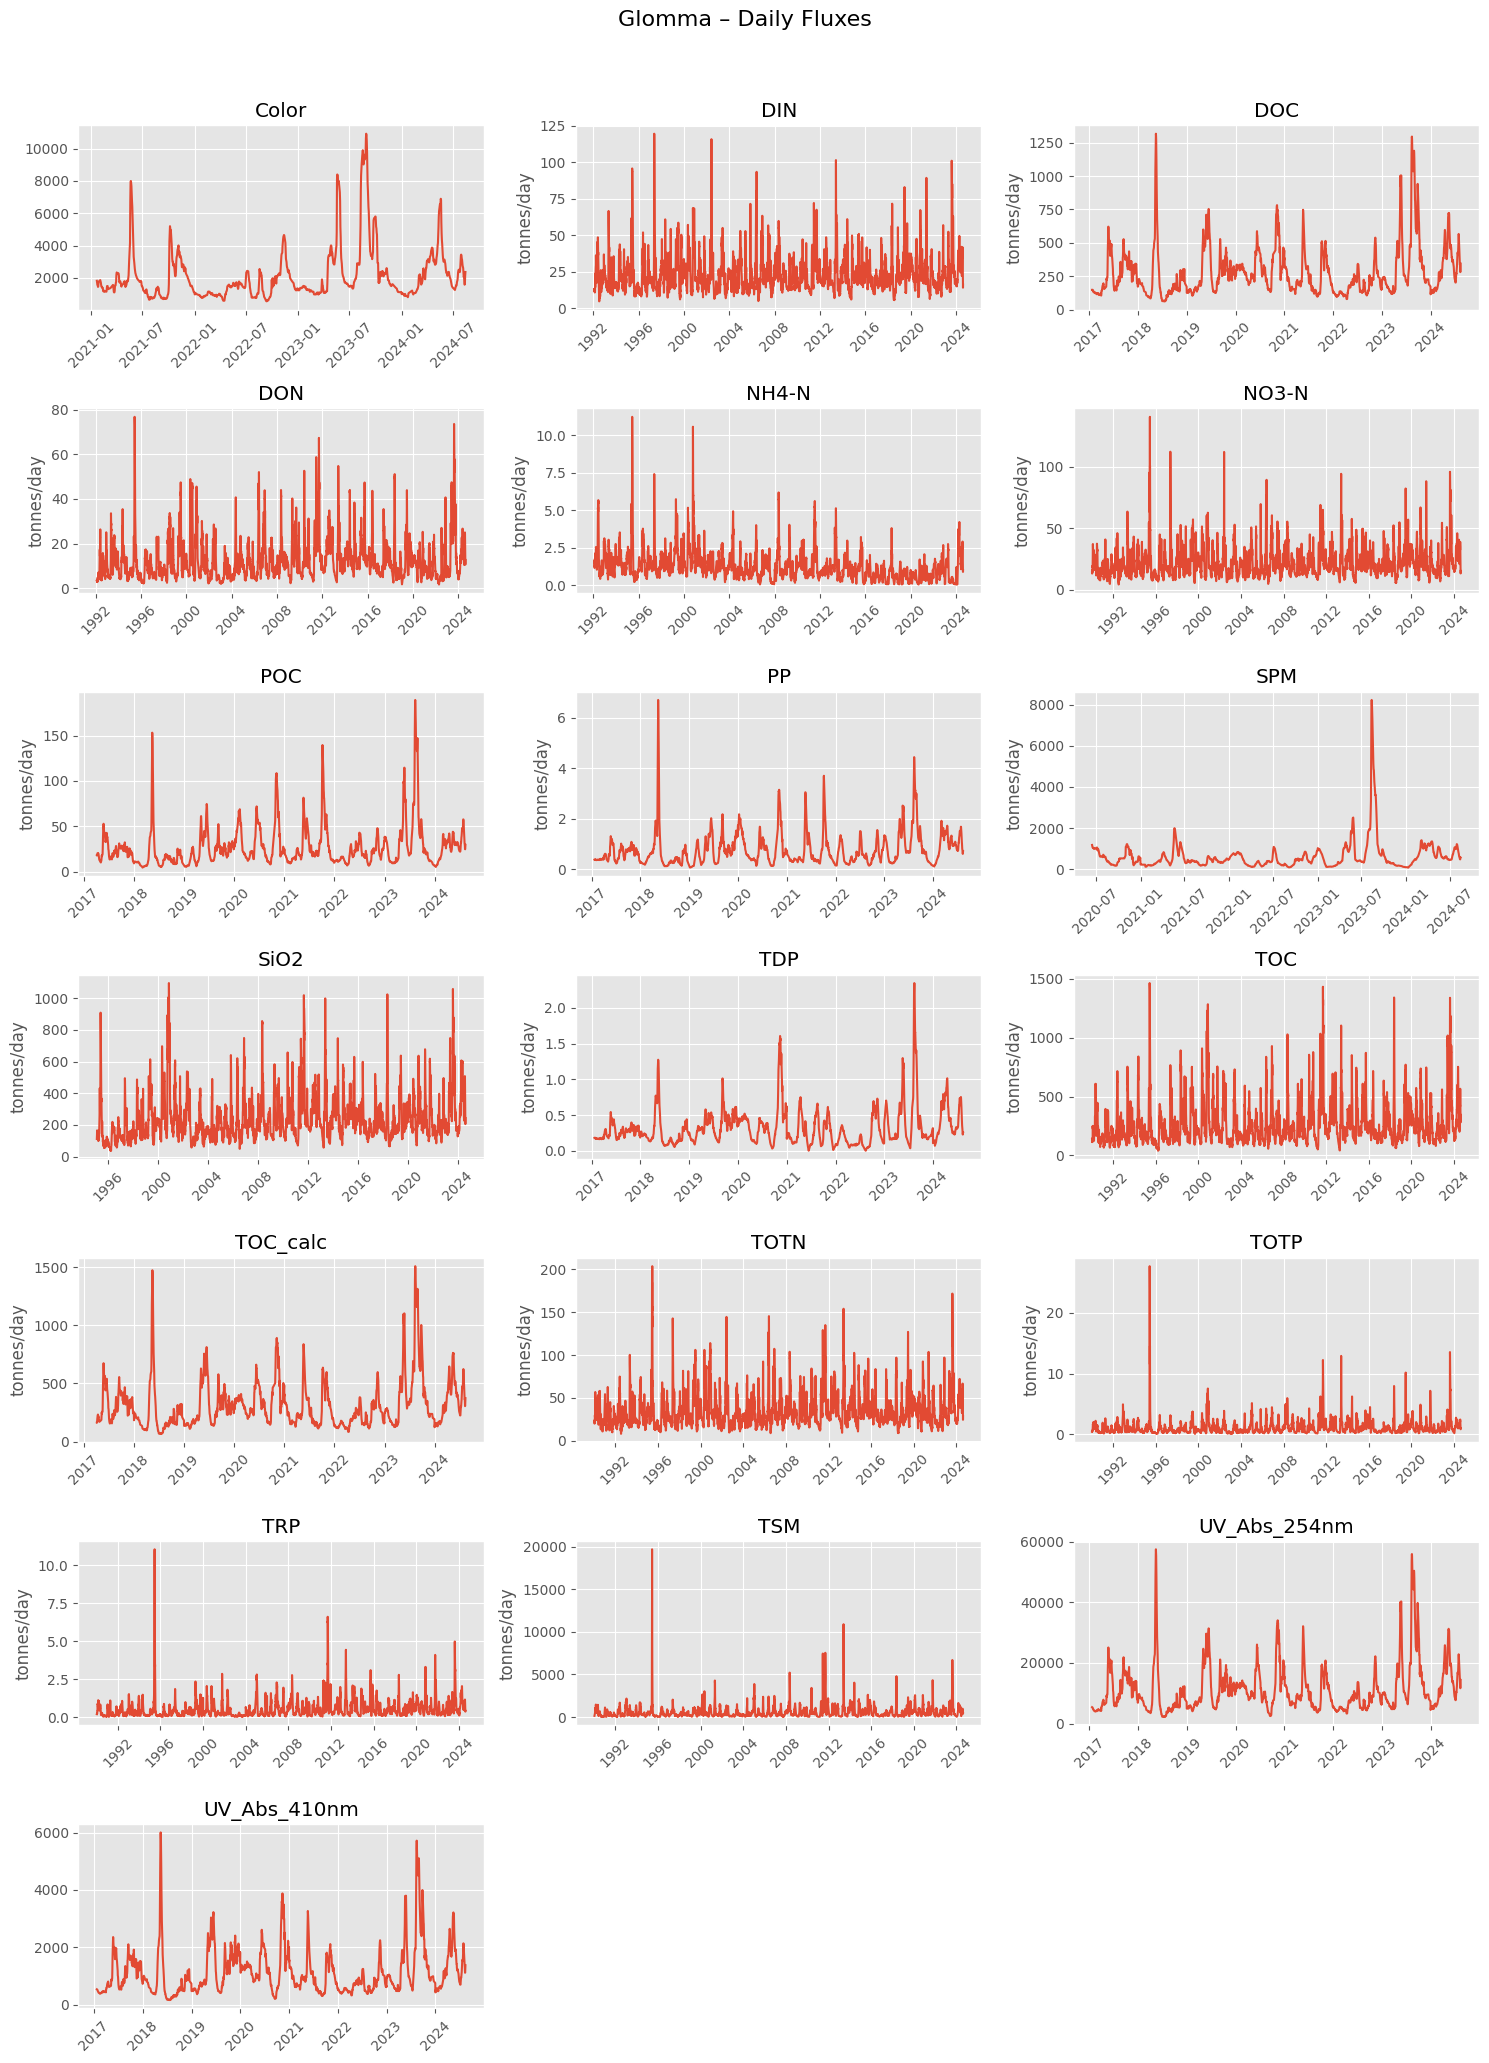

Saved plot to: ..\..\figures\wc_fluxes\drammenselva_daily_fluxes.png


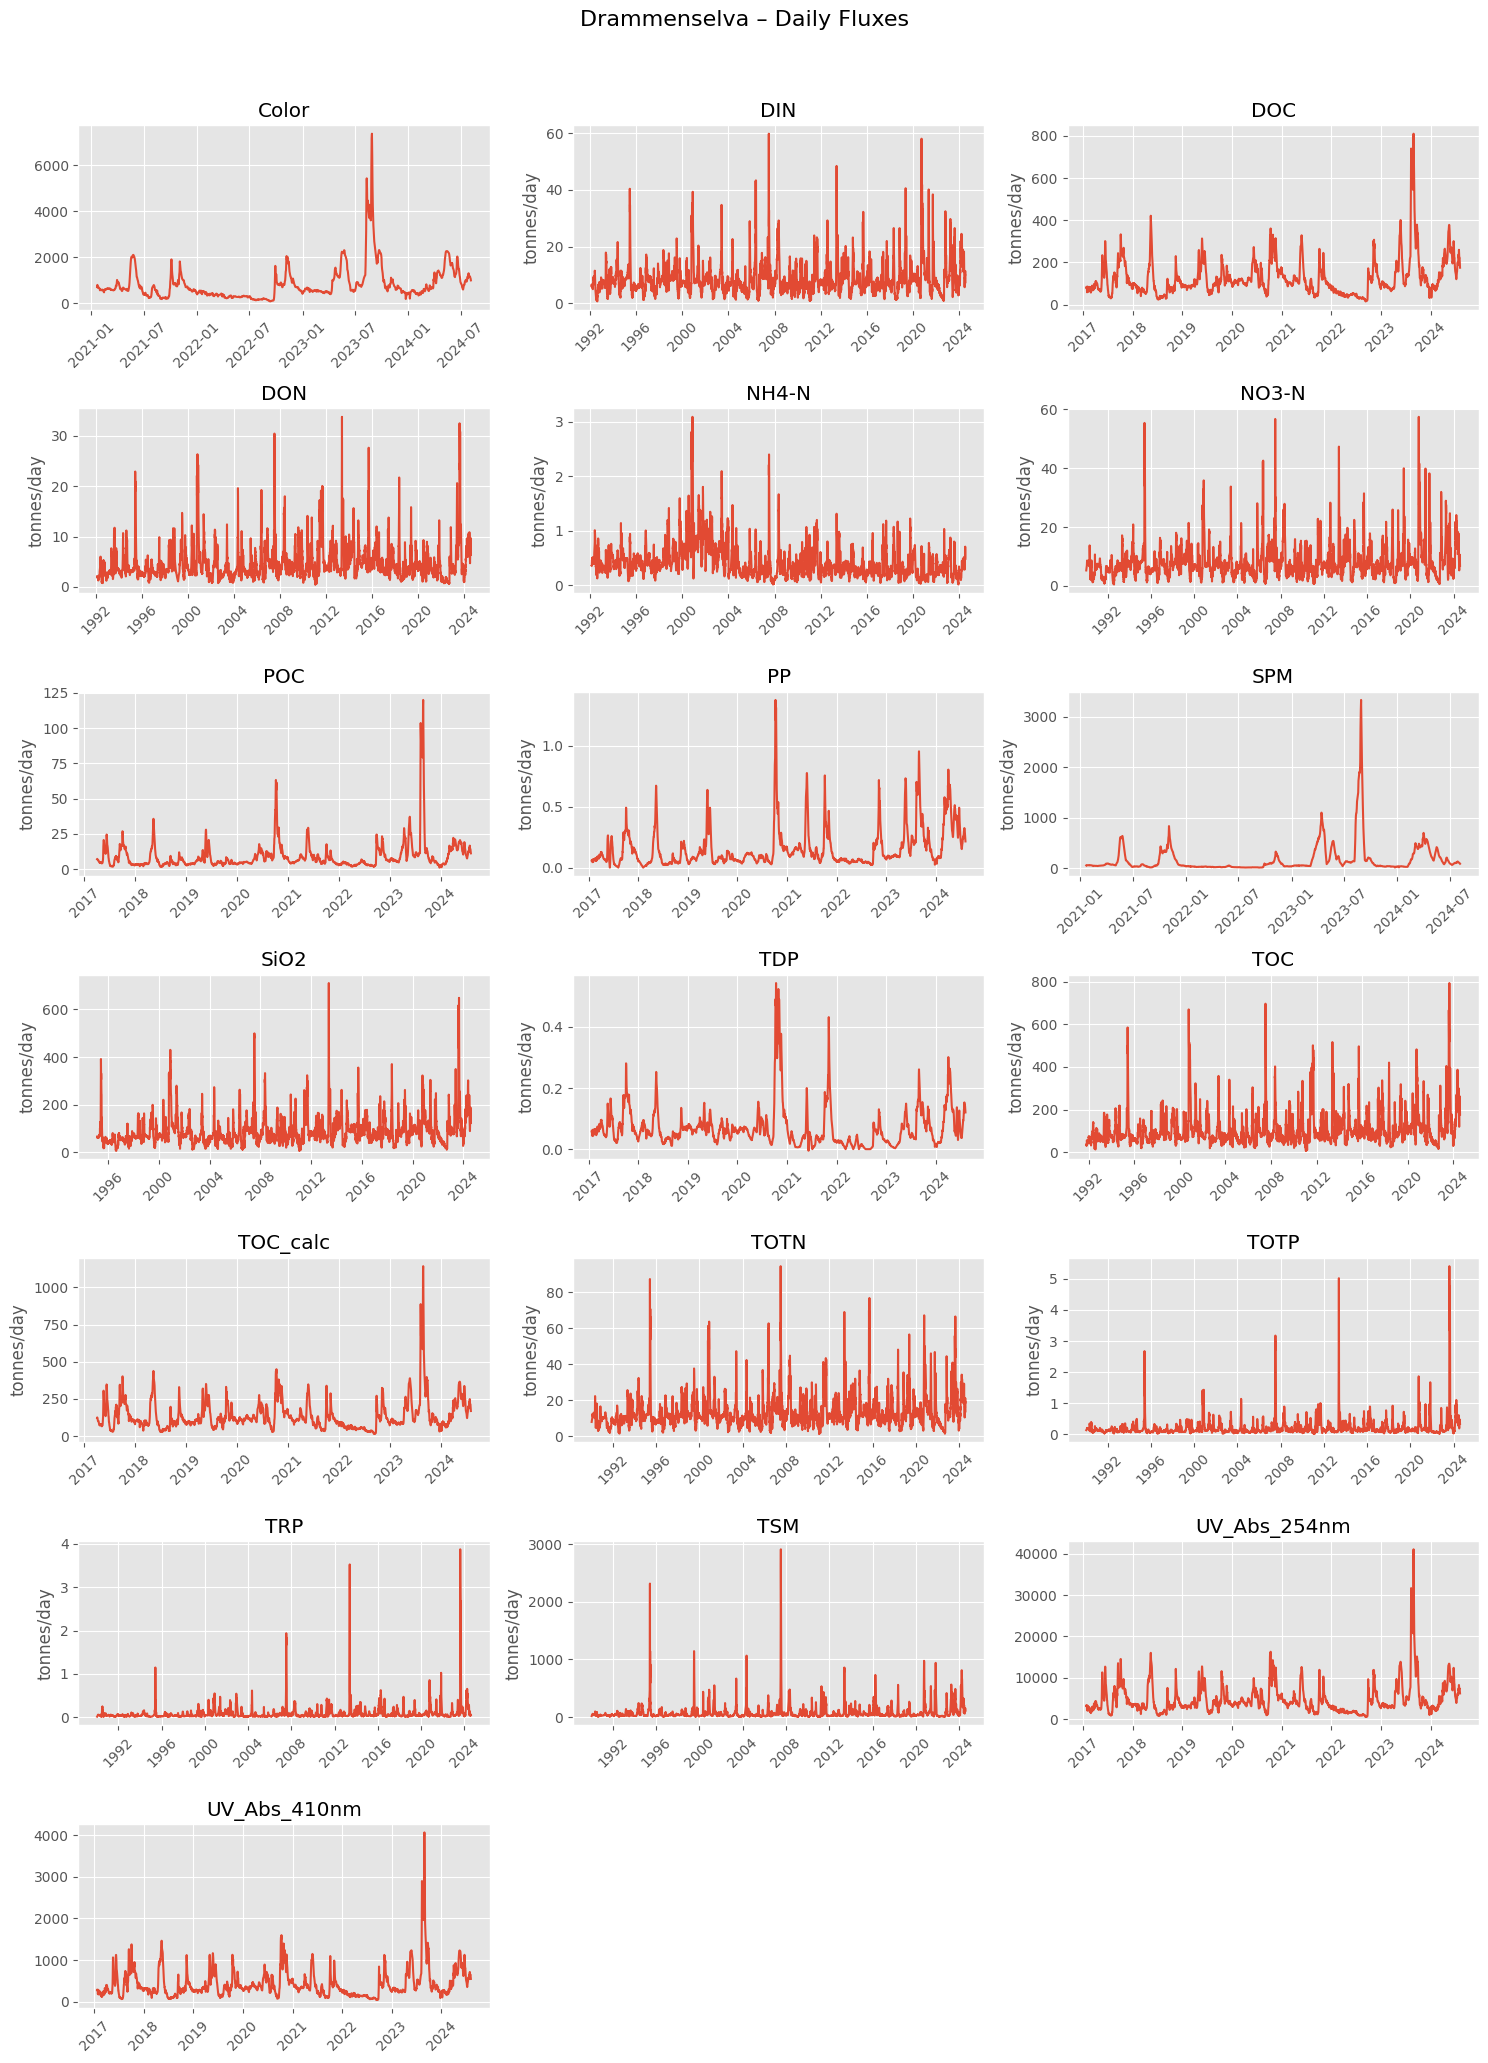

Saved plot to: ..\..\figures\wc_fluxes\numedalslagen_daily_fluxes.png


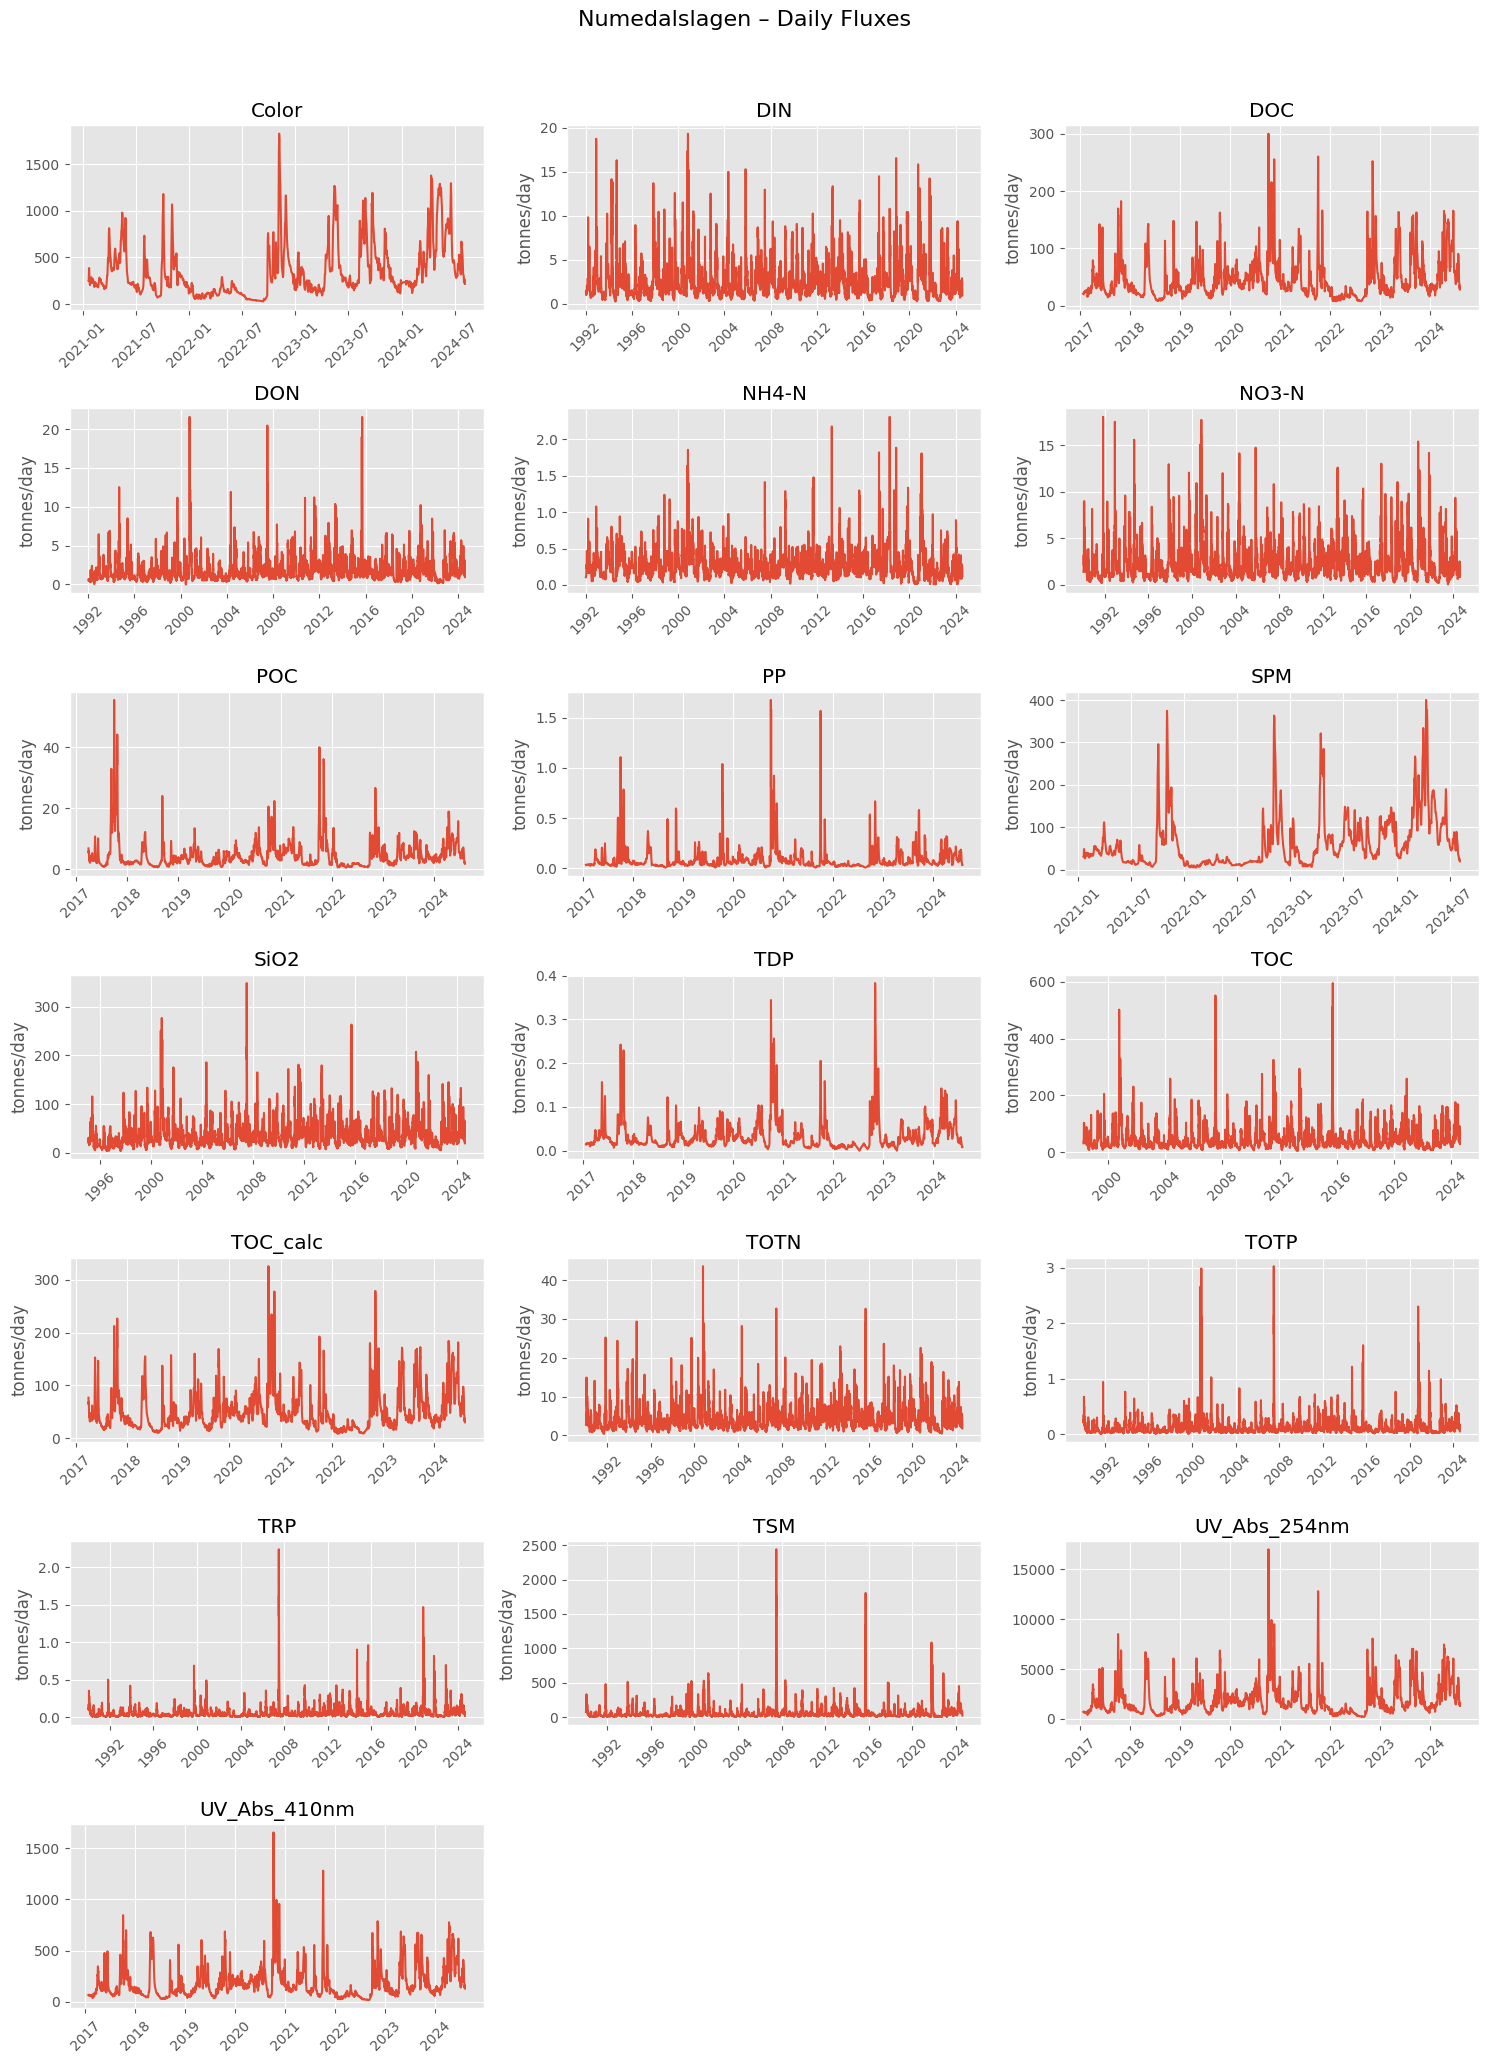

In [8]:
for river in rivers:
    save_path = plots_output_dir / f"{river.lower()}_daily_fluxes.png"
    plot_daily_fluxes(flux_results=daily_flux_results, station_filter=river, save_path=save_path)

#### 4.2. Monthly 

Saved plot to: ..\..\figures\wc_fluxes\glomma_monthly_fluxes.png


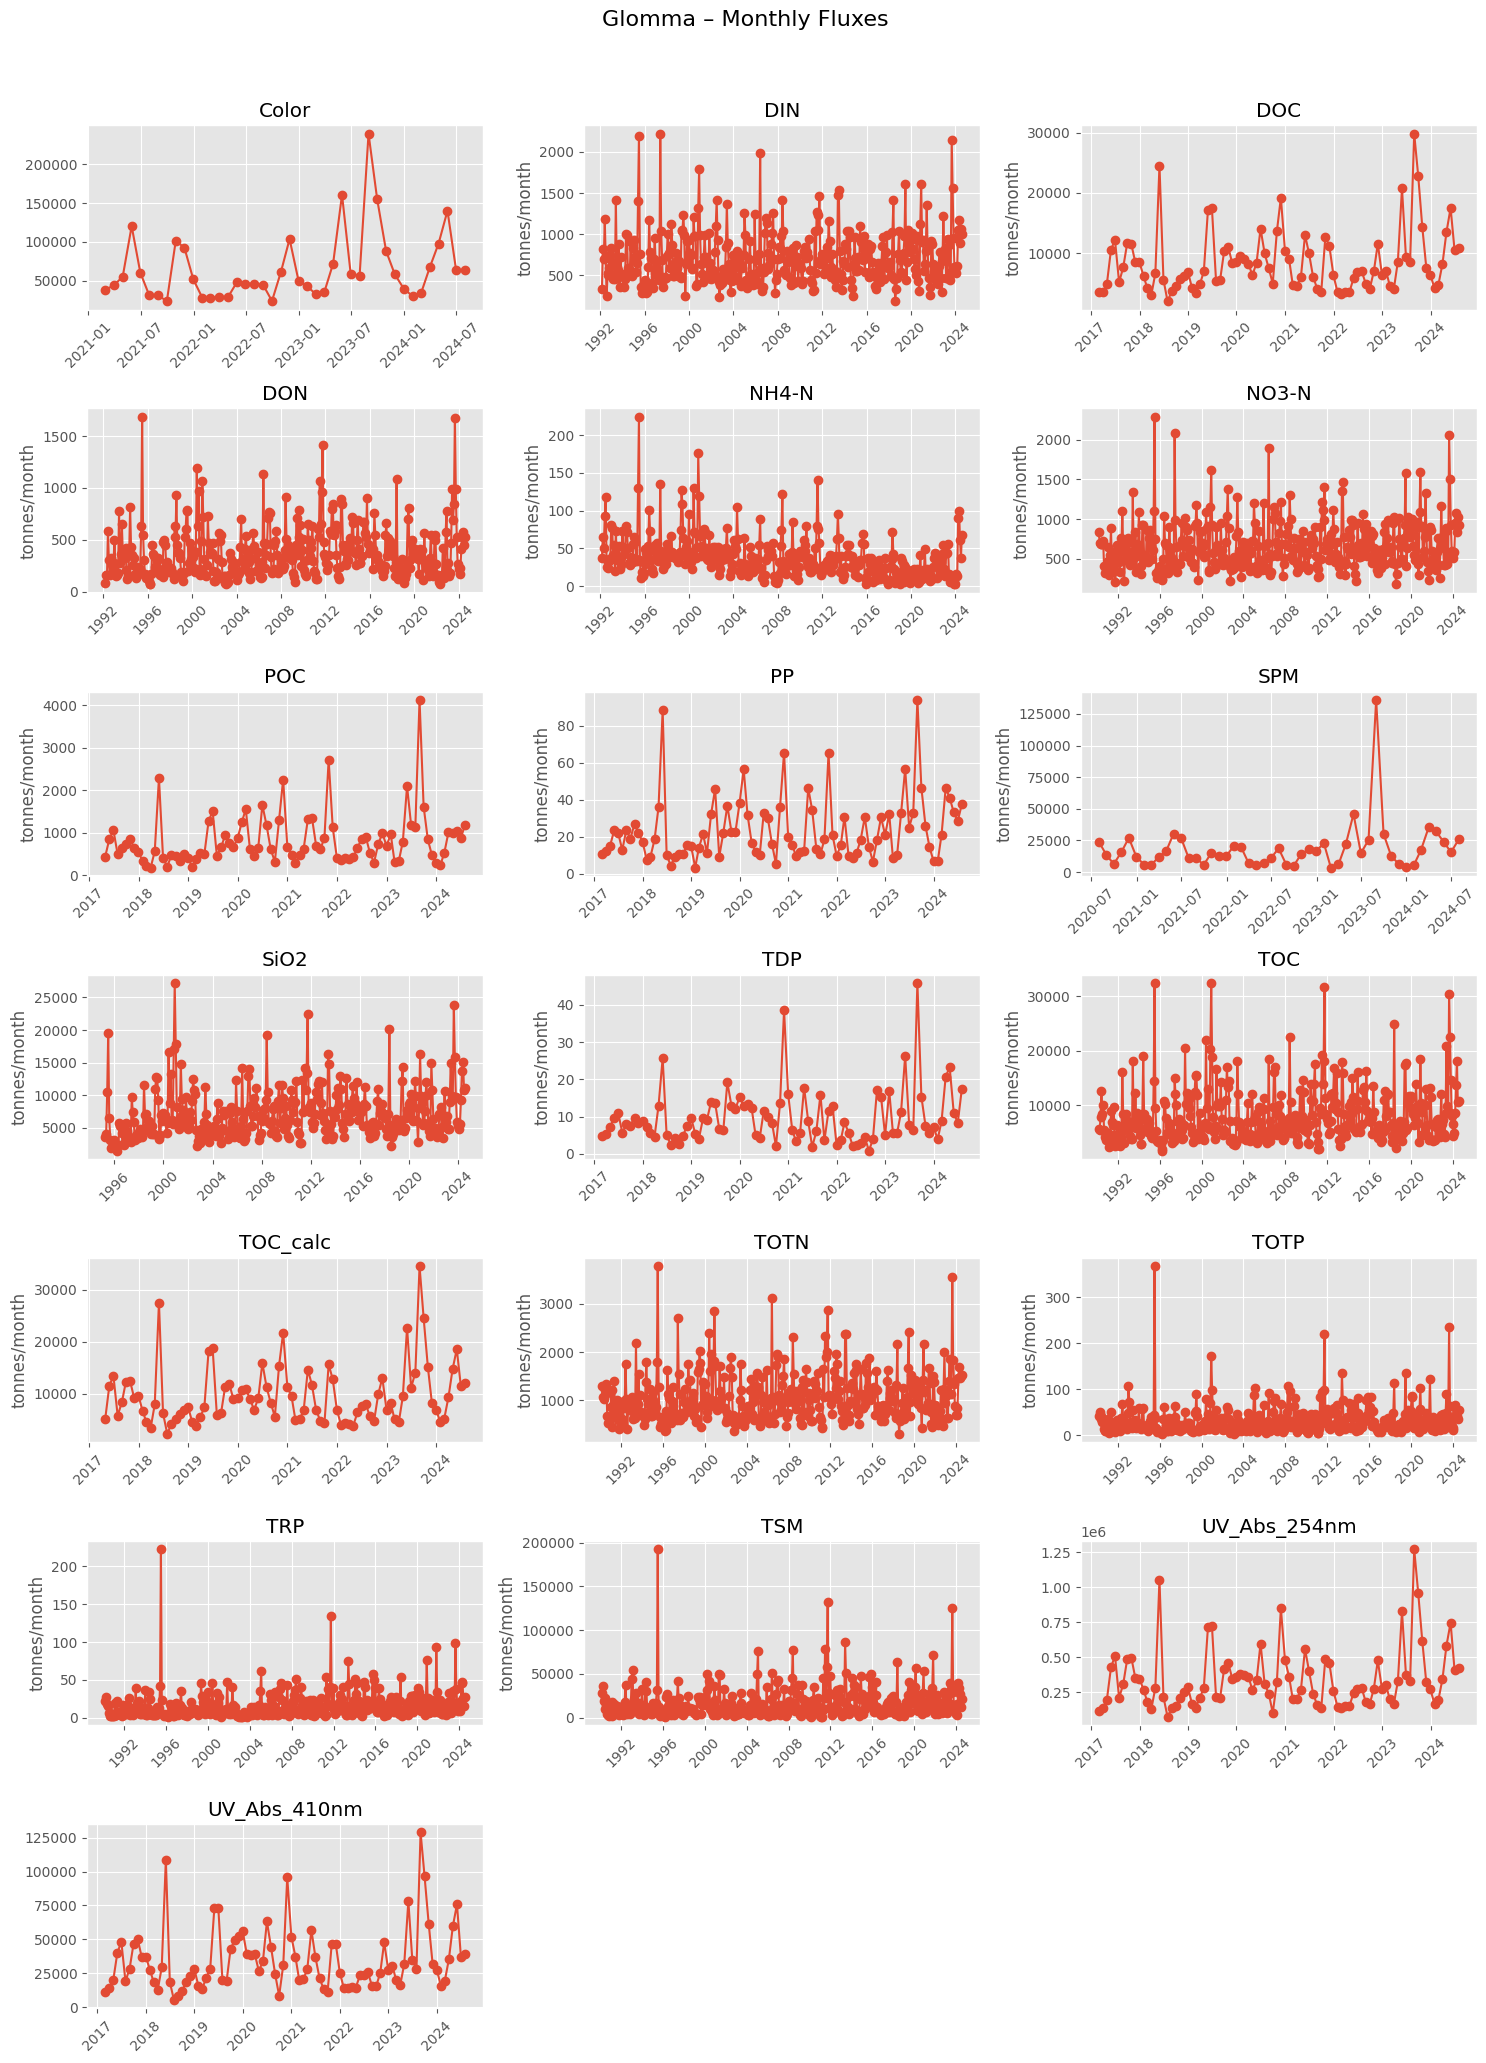

Saved plot to: ..\..\figures\wc_fluxes\drammenselva_monthly_fluxes.png


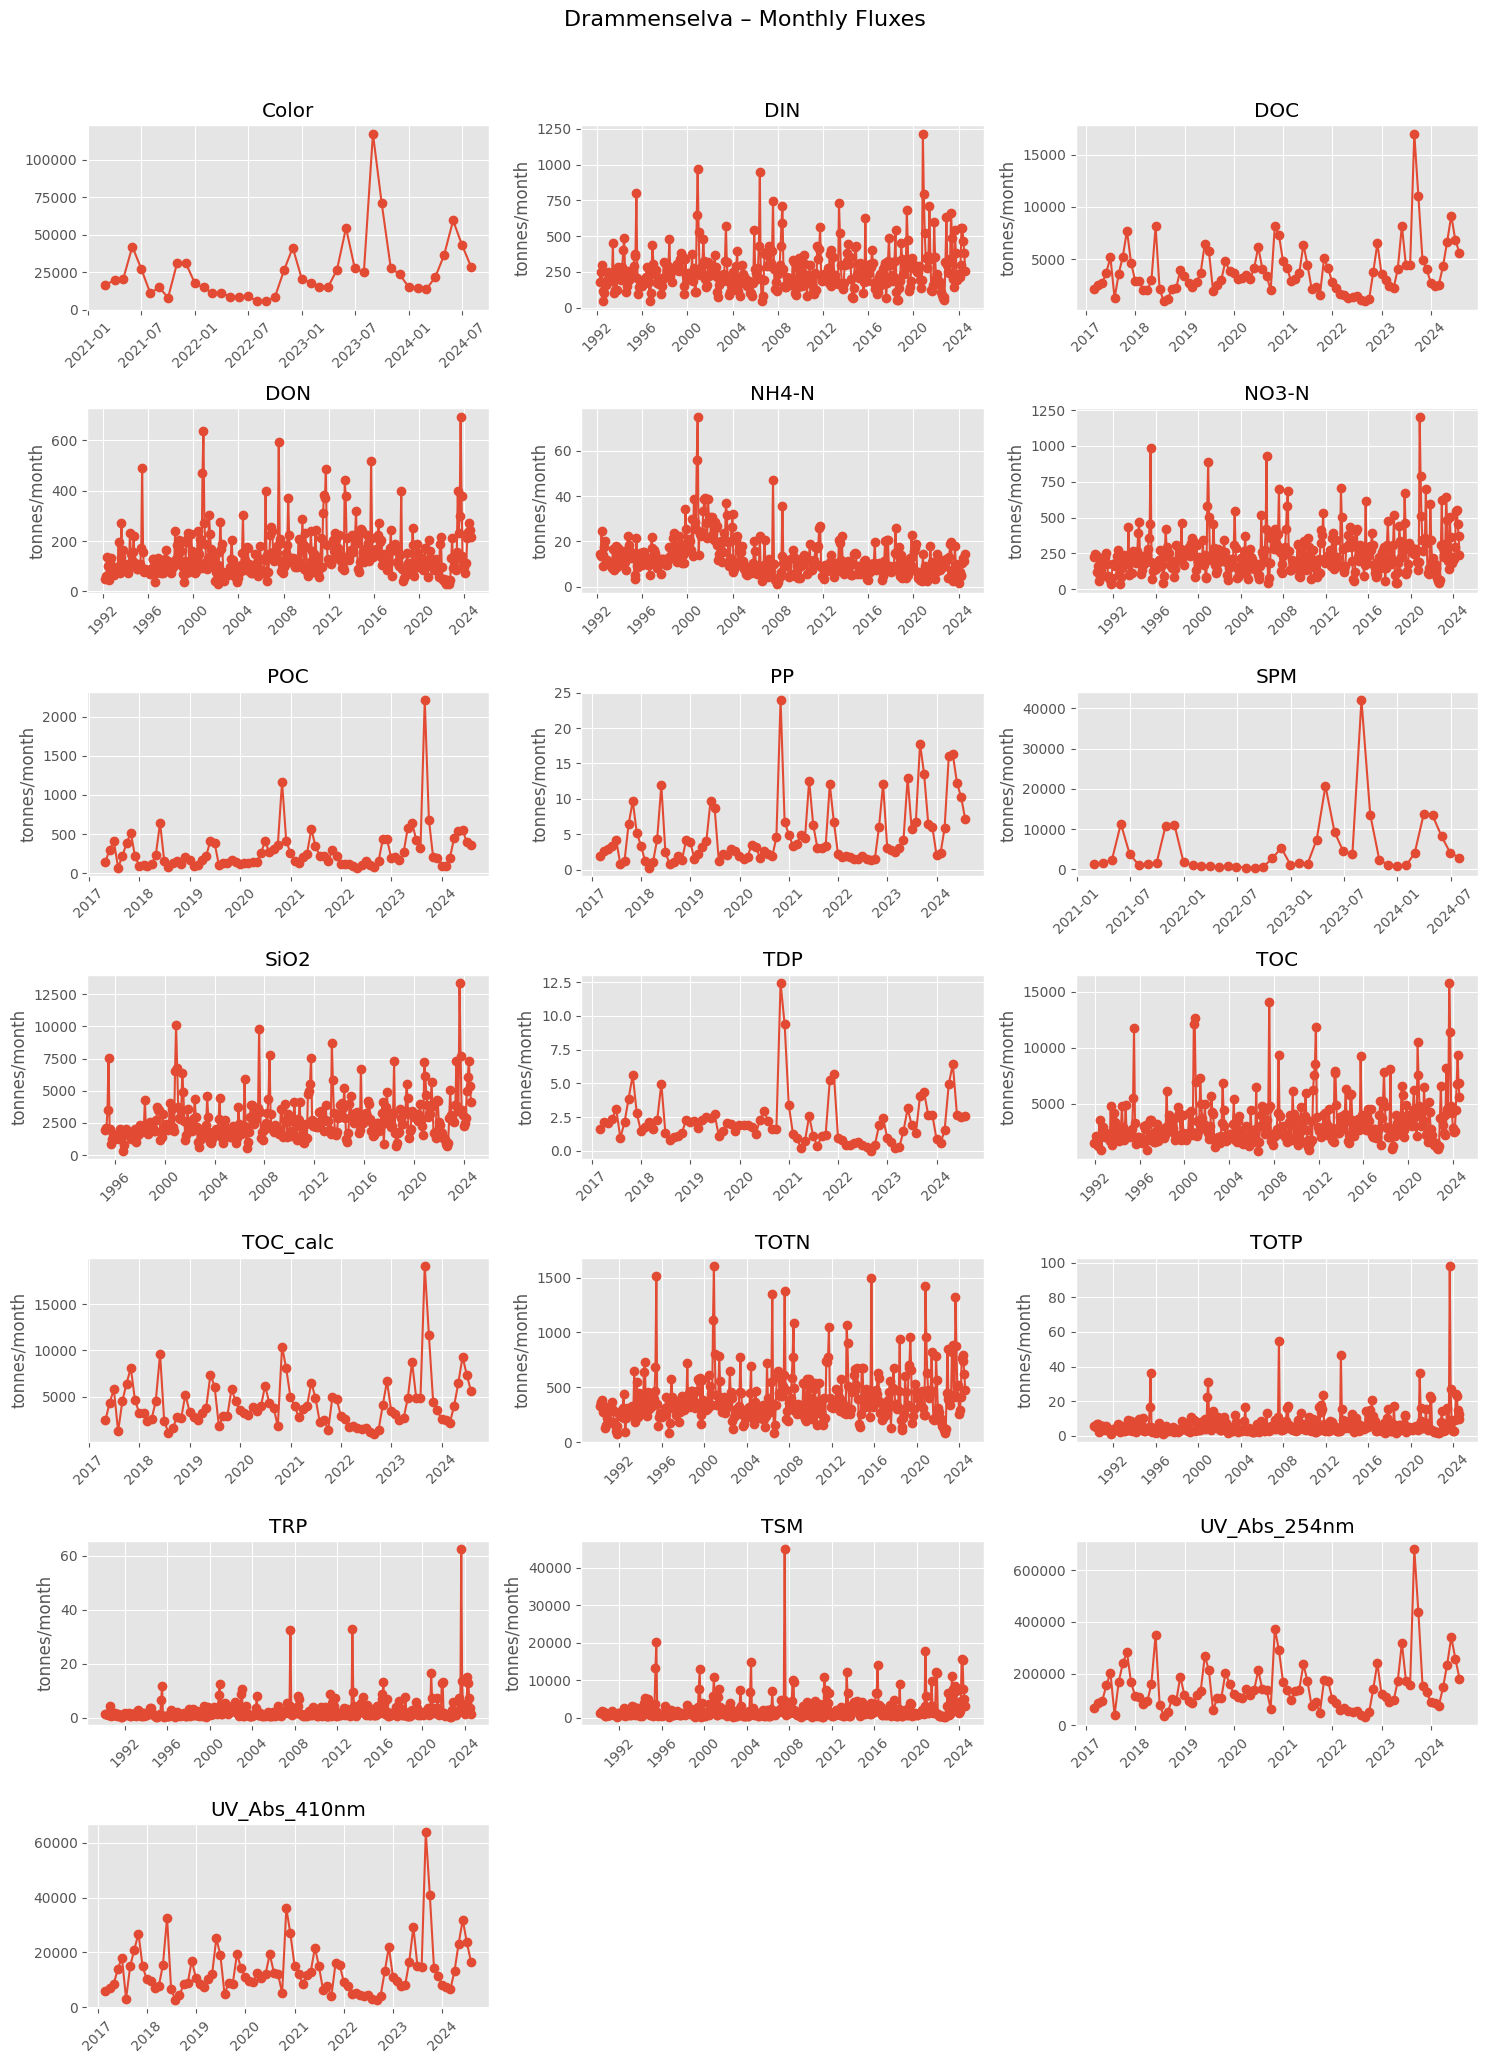

Saved plot to: ..\..\figures\wc_fluxes\numedalslagen_monthly_fluxes.png


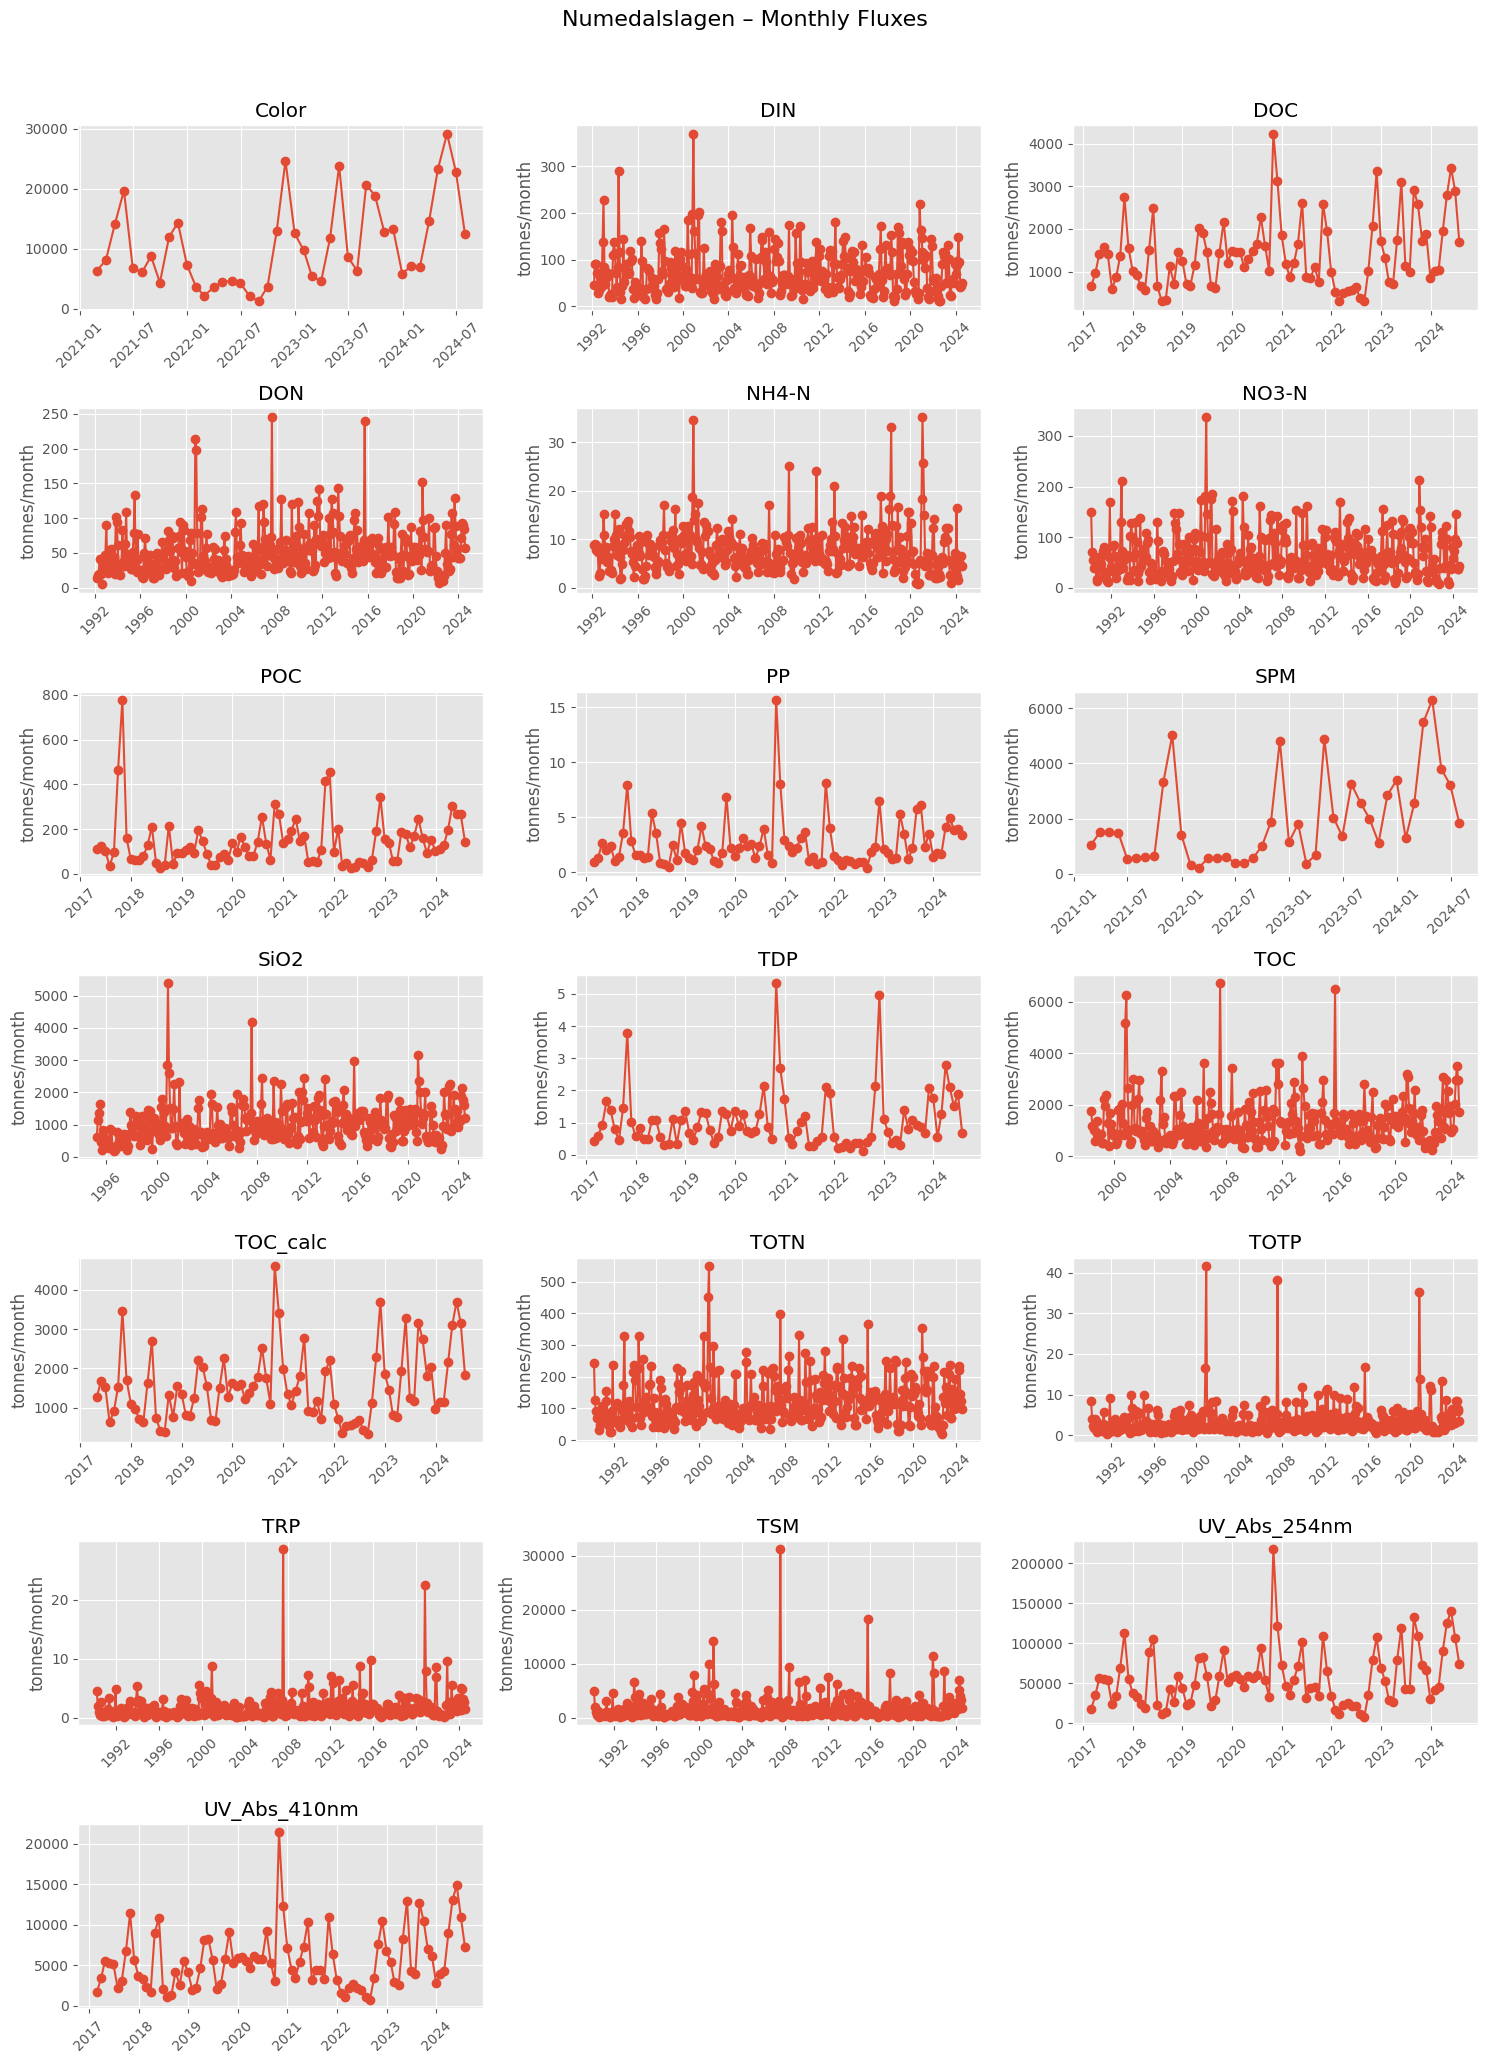

In [9]:
for river in rivers:
    save_path = plots_output_dir / f"{river.lower()}_monthly_fluxes.png"
    plot_monthly_fluxes(monthly_flux_results=monthly_flux_results, station_filter=river, save_path=save_path)

#### 4.3. Annual

Saved plot to: ..\..\figures\wc_fluxes\glomma_annual_fluxes.png


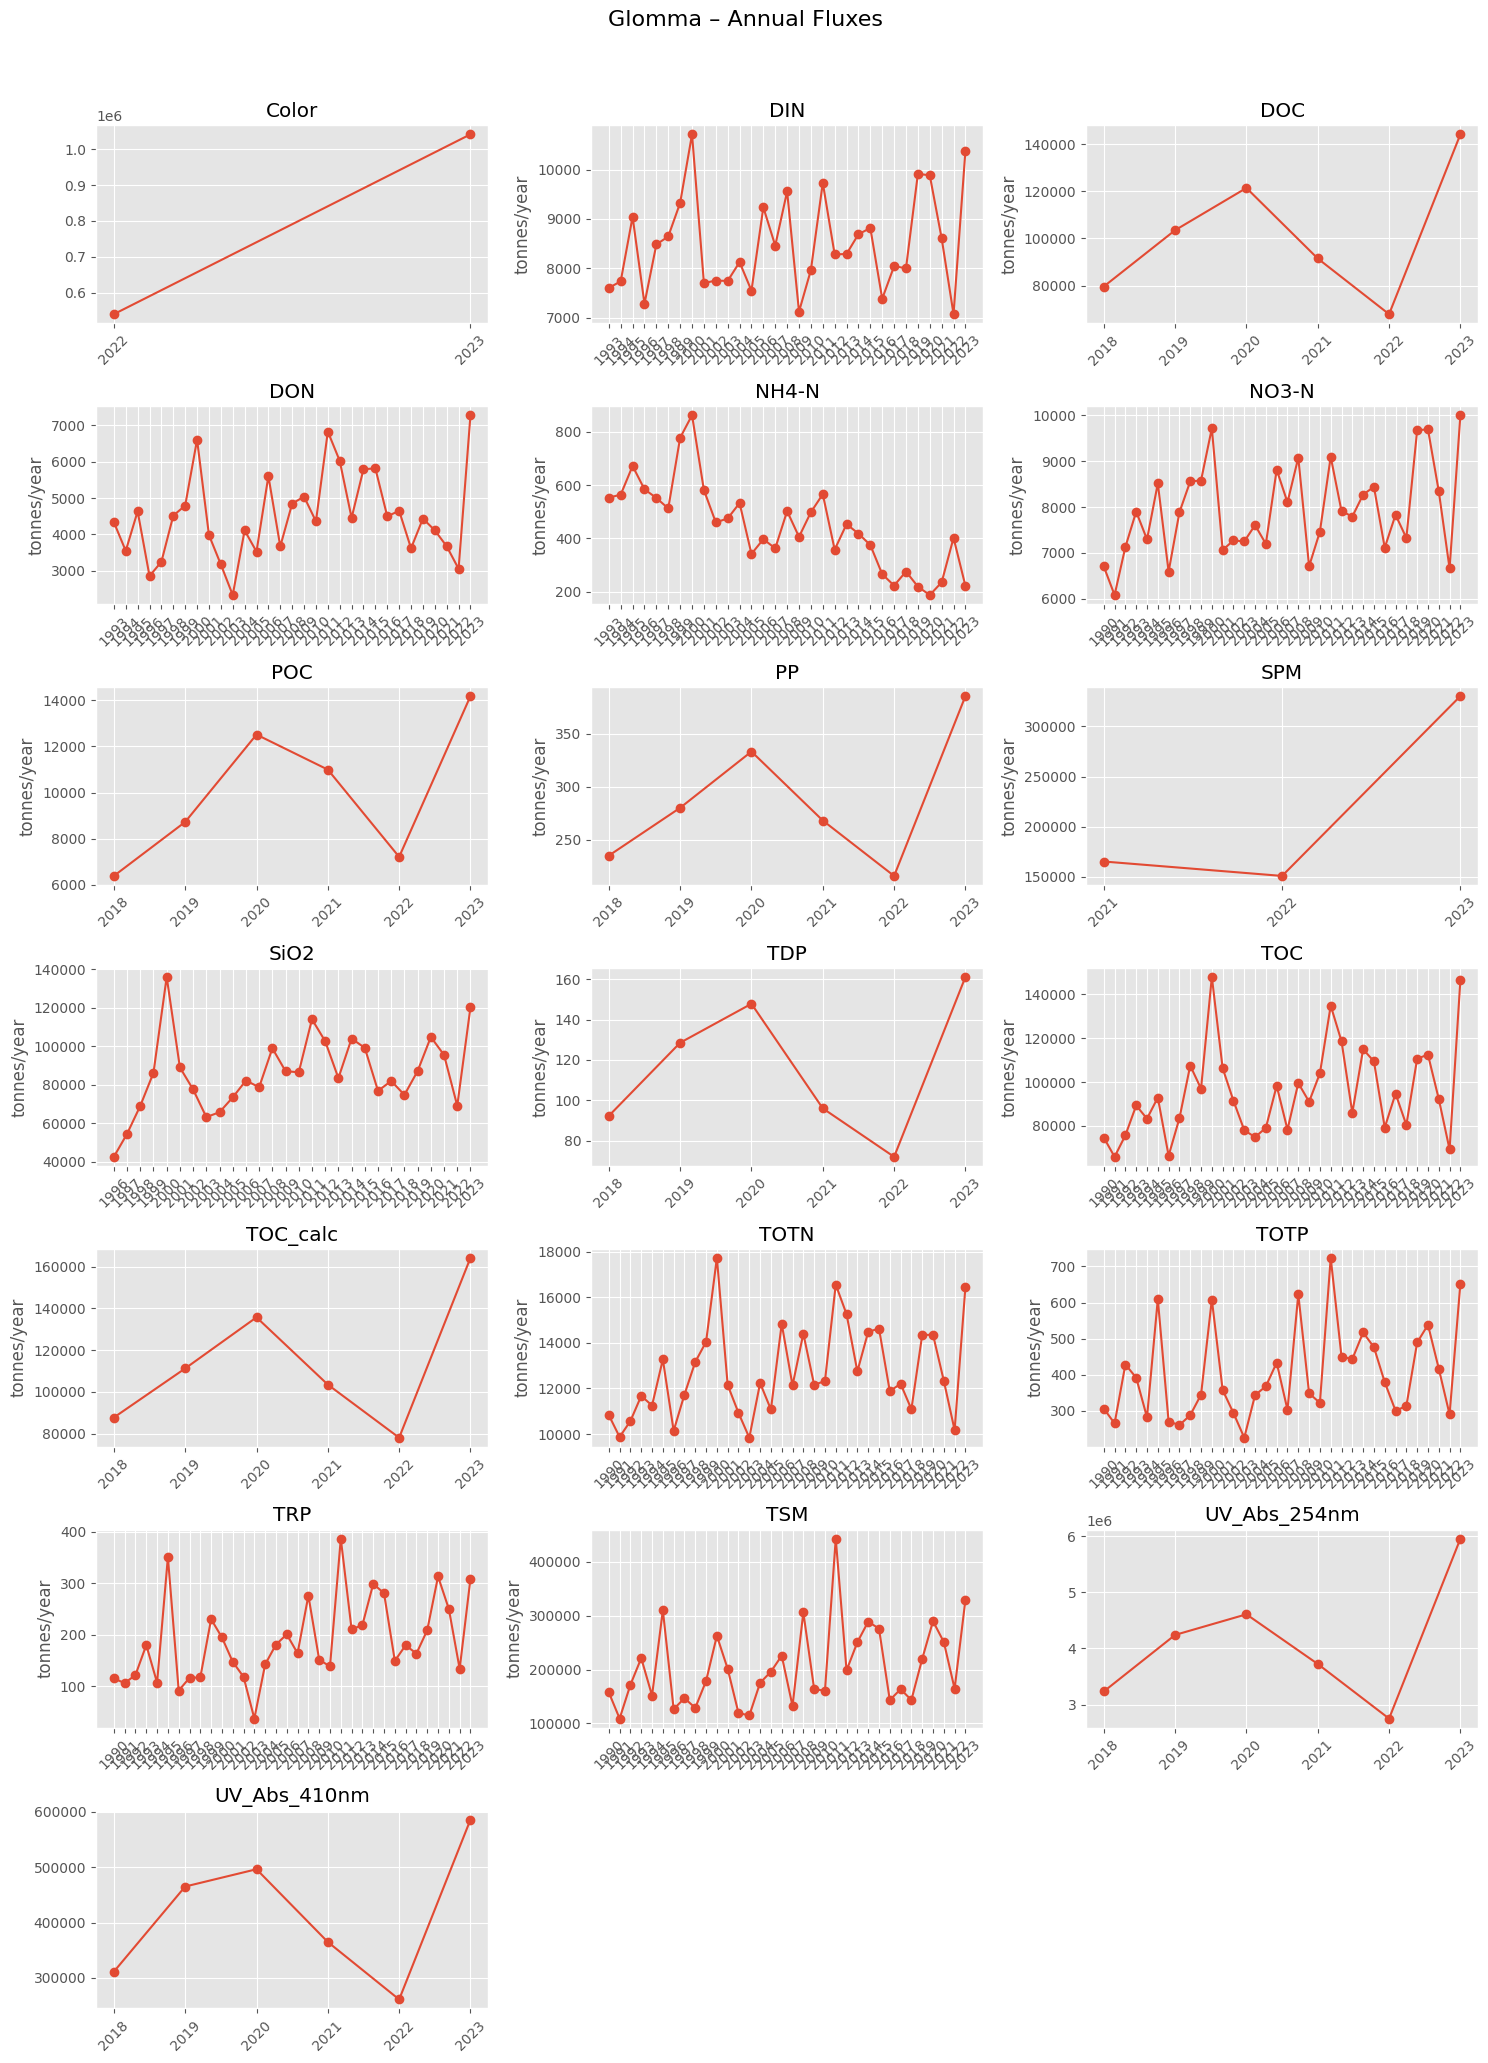

Saved plot to: ..\..\figures\wc_fluxes\drammenselva_annual_fluxes.png


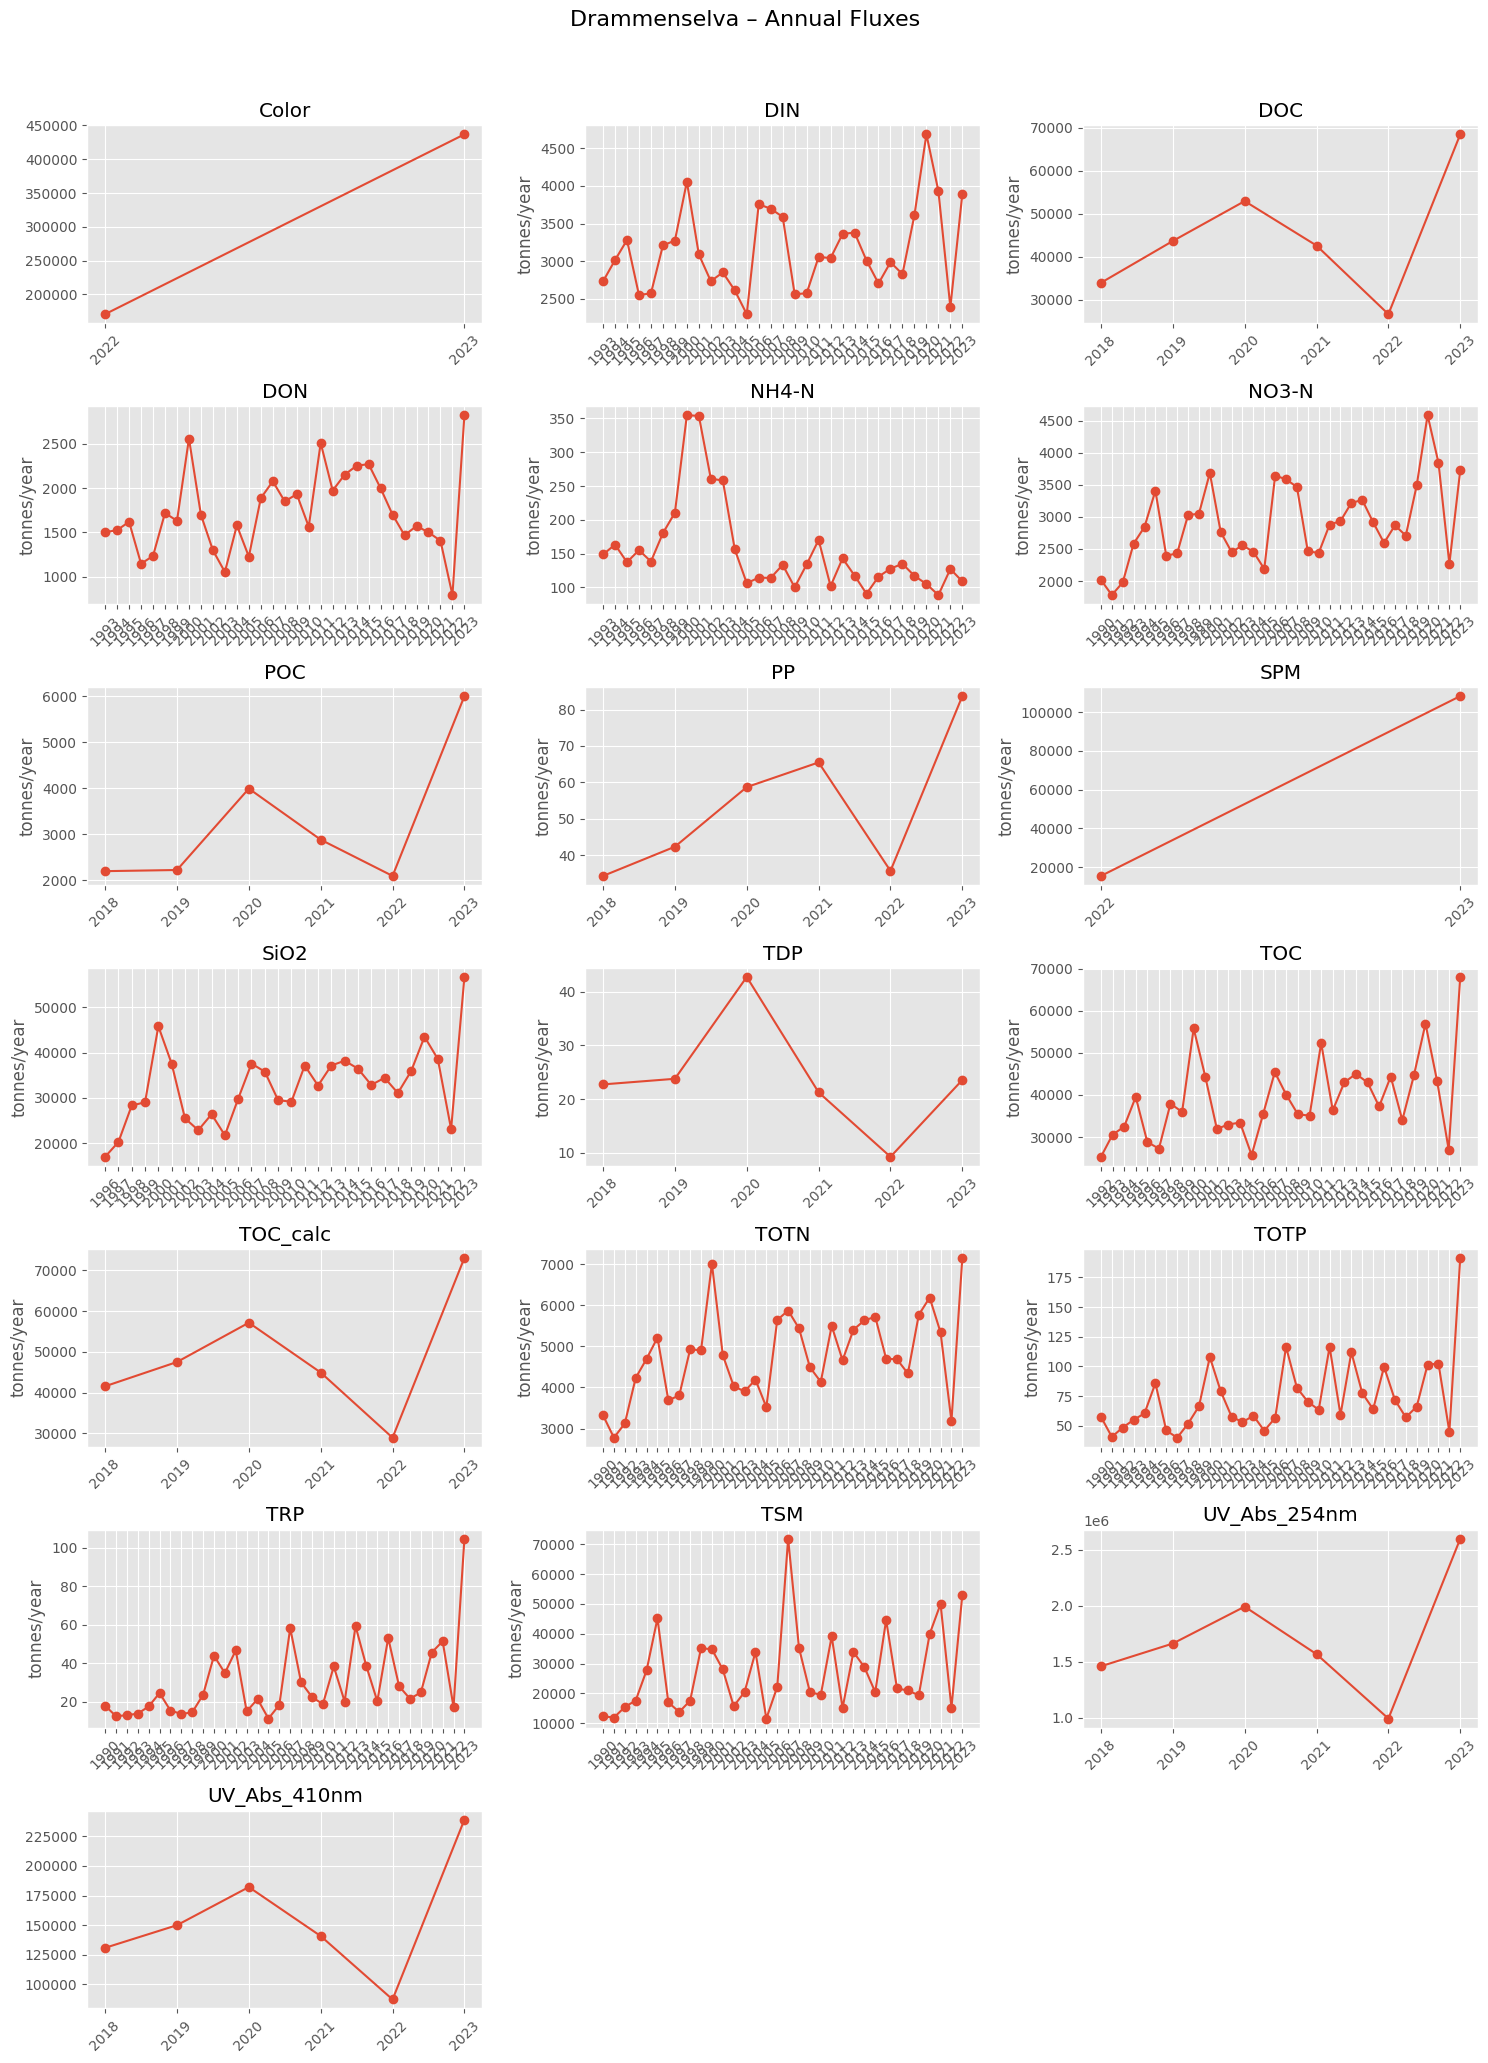

Saved plot to: ..\..\figures\wc_fluxes\numedalslagen_annual_fluxes.png


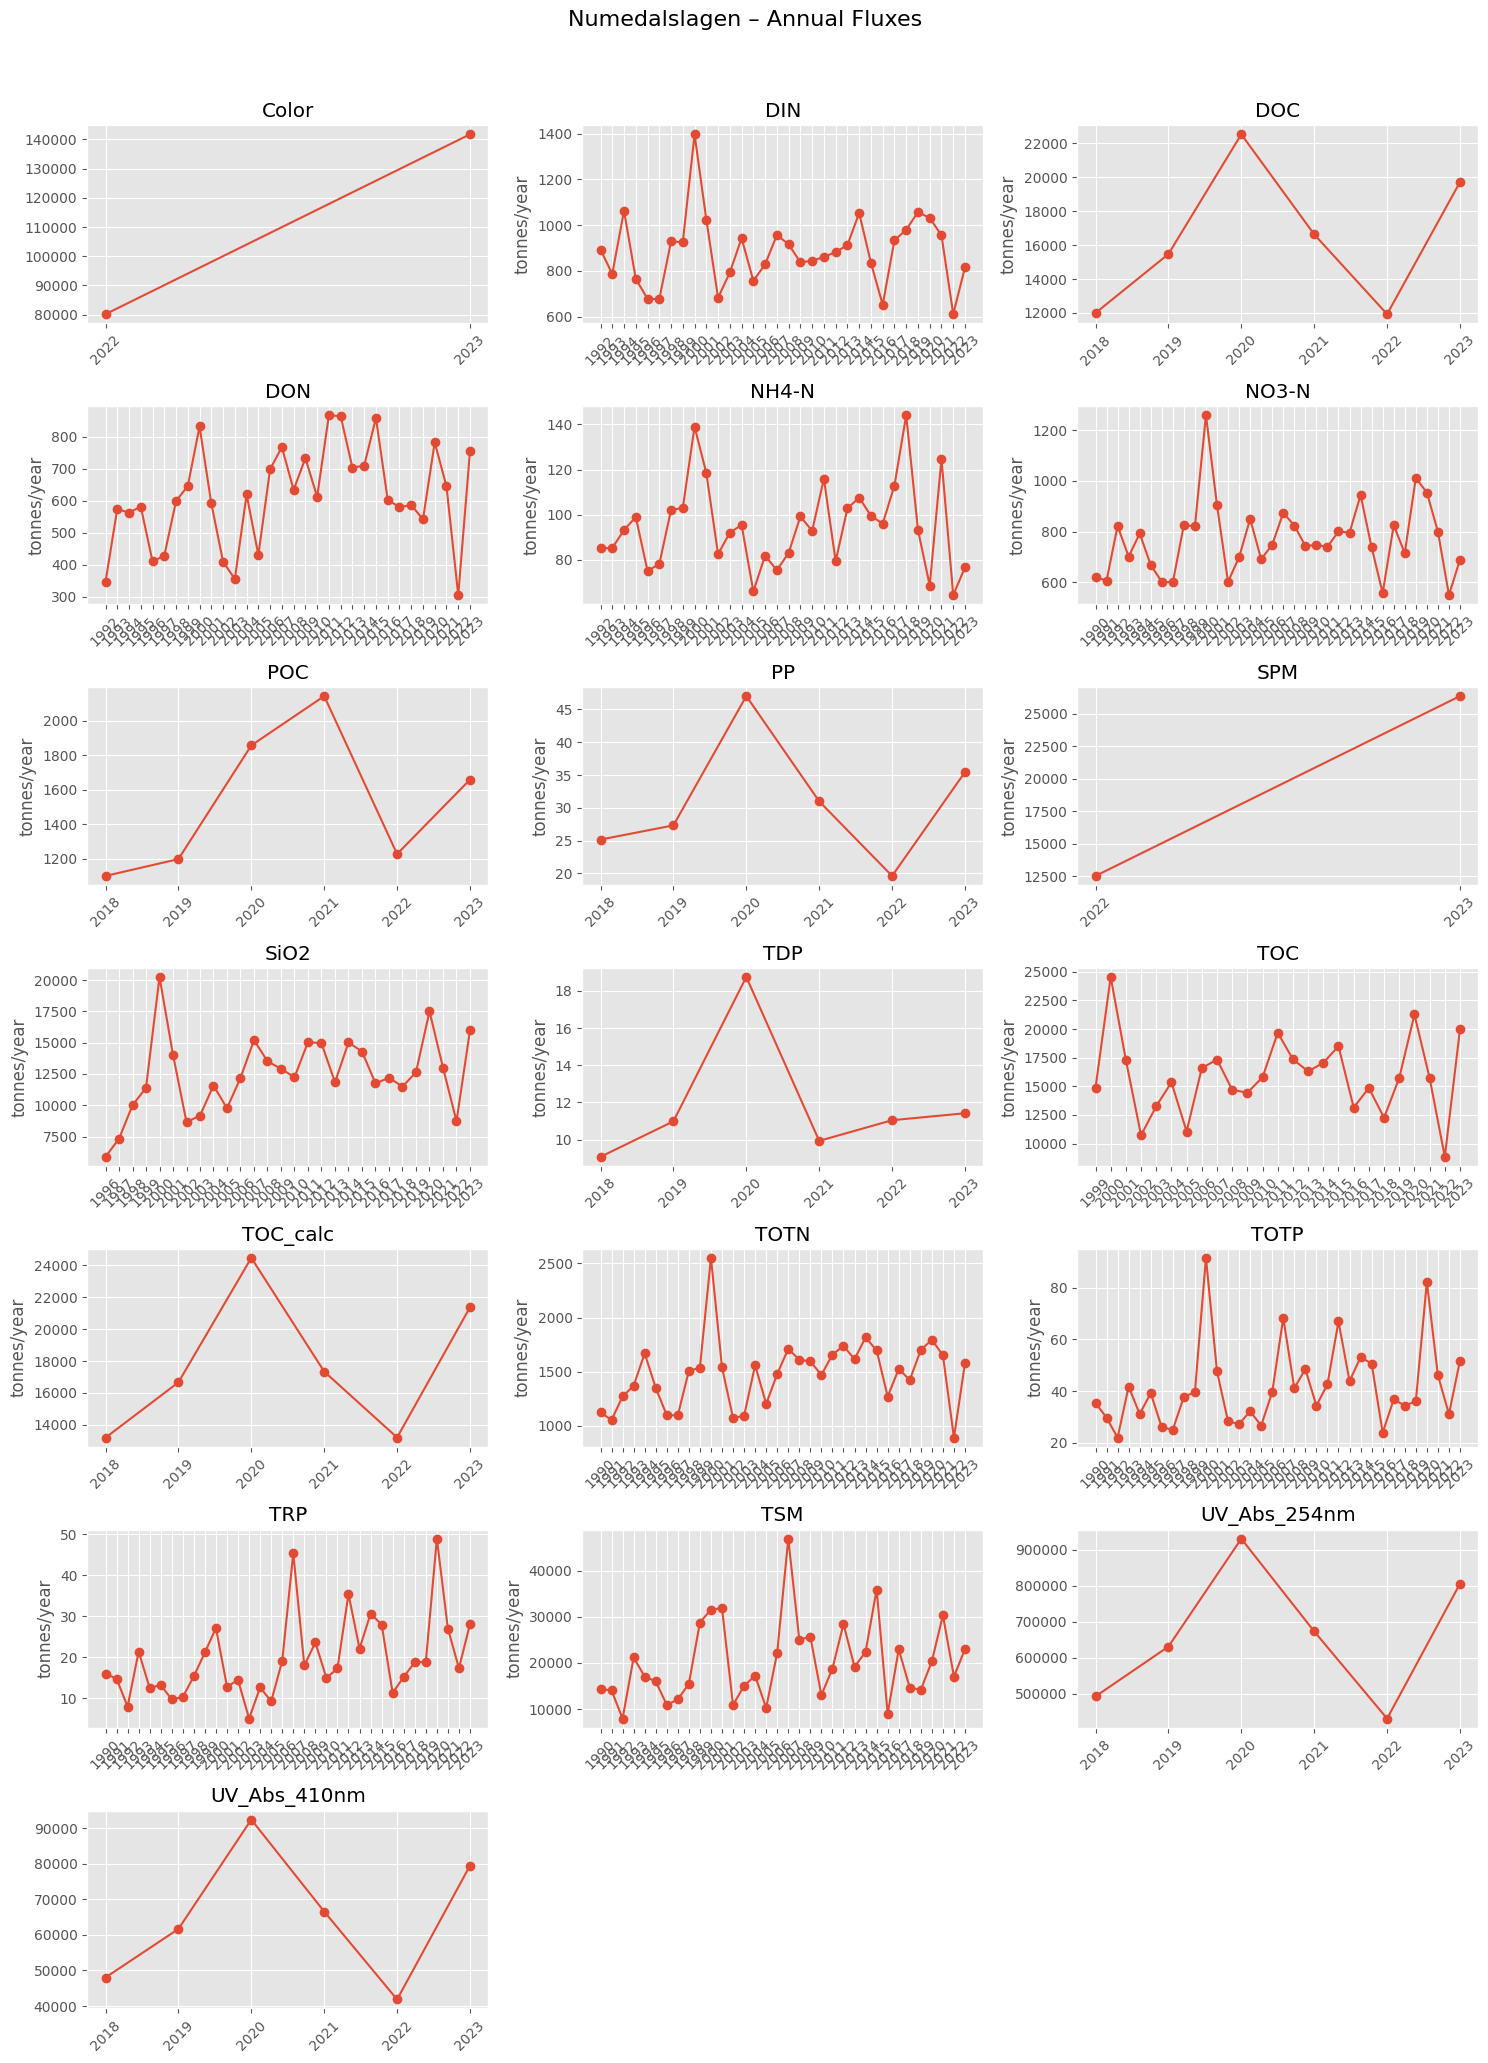

In [10]:
for river in rivers:
    save_path = plots_output_dir / f"{river.lower()}_annual_fluxes.png"
    plot_annual_fluxes(annual_flux_results=annual_flux_results, station_filter=river, save_path=save_path)

### 5. Create datasets and assign metadata and global attributes

In [11]:
flux_groups = {
    "daily": daily_flux_results,
    "monthly": monthly_flux_results,
    "annual": annual_flux_results
}

for label, results in flux_groups.items():
    save_flux_datasets_as_netcdf(
        flux_results=results,
        output_dir=os.path.join(output_dir, label),
        frequency_label=label,
        river_coords=river_coords,
        flux_metadata_df=flux_metadata_df,
        standard_name_map=standard_name_map,
        var_comments=var_comments,
        processed_namespace_uuid=processed_namespace_uuid,
        global_metadata_config=global_metadata_config,
    )

Saved: ..\..\data\river\water_chemistry\fluxes\daily\daily_water_chemistry_fluxes_drammenselva.nc
Saved: ..\..\data\river\water_chemistry\fluxes\daily\daily_water_chemistry_fluxes_glomma.nc
Saved: ..\..\data\river\water_chemistry\fluxes\daily\daily_water_chemistry_fluxes_numedalslagen.nc
Saved: ..\..\data\river\water_chemistry\fluxes\monthly\monthly_water_chemistry_fluxes_drammenselva.nc
Saved: ..\..\data\river\water_chemistry\fluxes\monthly\monthly_water_chemistry_fluxes_glomma.nc
Saved: ..\..\data\river\water_chemistry\fluxes\monthly\monthly_water_chemistry_fluxes_numedalslagen.nc
Saved: ..\..\data\river\water_chemistry\fluxes\annual\annual_water_chemistry_fluxes_drammenselva.nc
Saved: ..\..\data\river\water_chemistry\fluxes\annual\annual_water_chemistry_fluxes_glomma.nc
Saved: ..\..\data\river\water_chemistry\fluxes\annual\annual_water_chemistry_fluxes_numedalslagen.nc
